<div class="alert alert-block alert-success">

# **1.** **Setup**

<div>

In [1]:
from utils import *

In [2]:
# Set random seeds for reproducibility
tf.random.set_seed(221)
random.seed(221)
np.random.seed(221)
tf.random.set_seed(221)

## **1.1** Datasets

In [3]:
# Load the train/val split data
with open('train_val_split.pkl', 'rb') as f:
    data = pickle.load(f)

# Store the data in variables
x_train = data['x_train']
x_val = data['x_val']
y_train = data['y_train']
y_val = data['y_val']

In [4]:
# For EXTRA

# Load the train/val split data without preprocessing
with open('train_val_split_no_preproc.pkl', 'rb') as f:
    data_no_preproc = pickle.load(f)

# Convert DataFrames to list
train_texts = data_no_preproc['x_train'].tolist()
val_texts = data_no_preproc['x_val'].tolist()

# Convert Series to list
train_labels = data_no_preproc['y_train'].tolist()
val_labels = data_no_preproc['y_val'].tolist()

## **1.2** Parameters

In [5]:
# ------- Parameters ------- 
# Glove
emb_size = 50 # start small than increase to find the best value

# TF-IDF
max_df = 0.8 # we are removing terms that appear in >80% of tweets

# Word2Vec
window = 2         # context window size
min_count = 1      # minimum word frequency to include

# KNN
n_neighbors = 10
metric = 'cosine'
weights = 'distance'

# Naive Bayes
alpha = 1

# Random Forest
n_estimators = 200
criterion = 'gini'
max_depth = 20 # to control overfitting
min_samples_split = 10 # to avoid split on very small groups
min_samples_leaf = 3 # to avoid very specific rules
max_features = 'sqrt'
class_weight = 'balanced'

# Logistic Regression
penalty = 'elasticnet'
solver = 'saga'
l1_ratio = 0.5
C = 0.15
class_weight = 'balanced'
max_iter=300
multi_class='multinomial'

# XGBoost
objective='multi:softmax'
num_class=3
eval_metric='mlogloss'
use_label_encoder=False
learning_rate = 0.05 # for better convergence
max_depth_xgboost = 6
n_estimators_xgboost = 300
subsample = 0.8 # 80% of rows per tree to reduce overfitting
colsample_bytree = 1
scale_pos_weight = 1

# LSTM
batch_size=16
epochs=10
sg=1
learning_rate_lstm=0.001
optimizer=Adam(learning_rate=learning_rate_lstm)
loss='categorical_crossentropy'
metrics=['categorical_accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc', multi_label=True)]
units=64
dropout=0.3

## **1.3** General

In [6]:
corpus = x_train['text']

#get list with lenghts of sentences
train_len = []
for i in corpus:
    train_len.append(len(i))

vector_size = max(train_len)

metrics_df = []

In [7]:
tokenized_train = [word_tokenize(tweet.lower()) for tweet in x_train['text']]
max_seq_len = max(len(tokens) for tokens in tokenized_train)

## **1.4** Models

### Glove

In [8]:
model_name = 'glove-twitter'
glove_model = gensim.downloader.load(f'{model_name}-{emb_size}')

### Text Embeddings 3 Small

In [9]:
# EXTRA

# Load variables from .env into environment
load_dotenv()

# Print environment variable
print("AZURE_OPENAI_ENDPOINT:", os.getenv("AZURE_OPENAI_ENDPOINT"))

# Initialize Azure OpenAI client
client = AzureOpenAI(
    api_key=os.getenv("AZURE_OPENAI_KEY"),
    api_version="2024-02-01",
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT")
)

# Define embedding model
model = "text-embedding-3-small"

AZURE_OPENAI_ENDPOINT: https://novaimsplayground.openai.azure.com/


In [10]:
# Define embedding model text embedding
model_te3s = "text-embedding-3-small"

### Roberta

In [11]:
# Load the pre-trained model and tokenizer for roberta
model_name = "cardiffnlp/twitter-roberta-base"
tokenizer_roberta = AutoTokenizer.from_pretrained(model_name)
model_roberta = AutoModel.from_pretrained(model_name)

### LSTM

In [12]:
input_ = Input(shape=(max_seq_len, vector_size))

x = Masking(mask_value=0.0)(input_)
x = Bidirectional(LSTM(units=units, return_sequences=False, dropout=dropout, recurrent_dropout=dropout))(x)
x = Dropout(dropout)(x)
output = Dense(num_class, activation='softmax')(x)

<div class="alert alert-block alert-success">

# **2.** **KNN**

<div>

## **2.1** Bag of Words

### **2.1.1** Unigrams

In [13]:
modelknn = KNeighborsClassifier(n_neighbors = n_neighbors, metric = metric, weights = 'distance')

# each term is marked as present or not per document - good for short text
X_bow_unigrams, y_train_pred_bow_unigrams, y_val_pred_bow_unigrams, bow_unigrams = embedding_bow(x_train=x_train, y_train=y_train, x_val=x_val, model=modelknn)

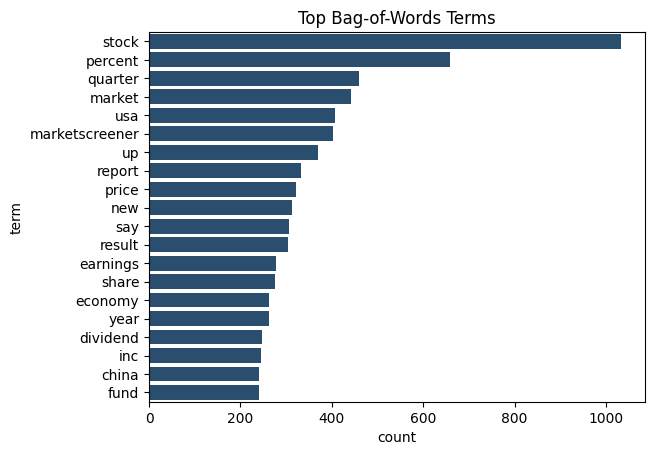

In [14]:
clean_bow_sum = np.array(X_bow_unigrams.sum(axis=0)).flatten()
clean_terms = bow_unigrams.get_feature_names_out()
clean_top = pd.DataFrame({'term': clean_terms, 'count': clean_bow_sum}).sort_values(by='count', ascending=False).head(20)

sns.barplot(data=clean_top, x='count', y='term', color='#1f4e79')
plt.title("Top Bag-of-Words Terms")
plt.show()

In [15]:
title = "KNN BoW Unigrams"

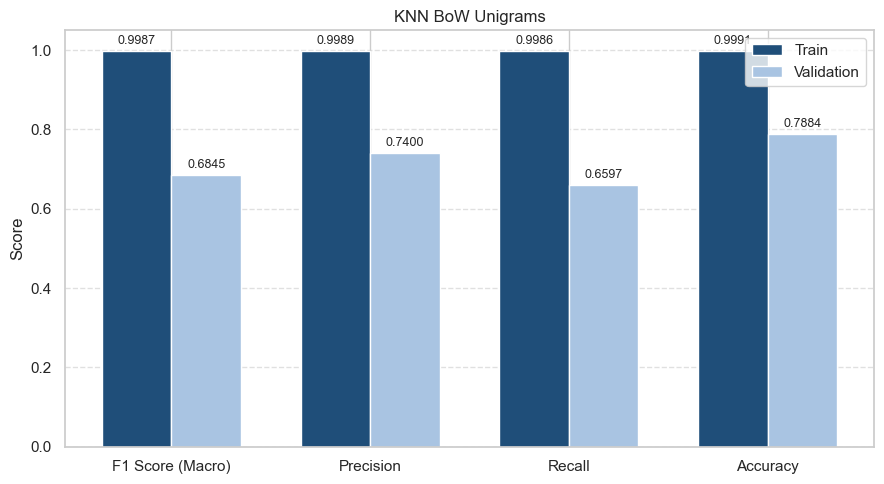

In [16]:
metrics_df.append(get_metrics_df(title, y_train, y_train_pred_bow_unigrams, y_val, y_val_pred_bow_unigrams))

# Plot metrics
plot_metrics(y_train, y_train_pred_bow_unigrams, y_val, y_val_pred_bow_unigrams, title=title)

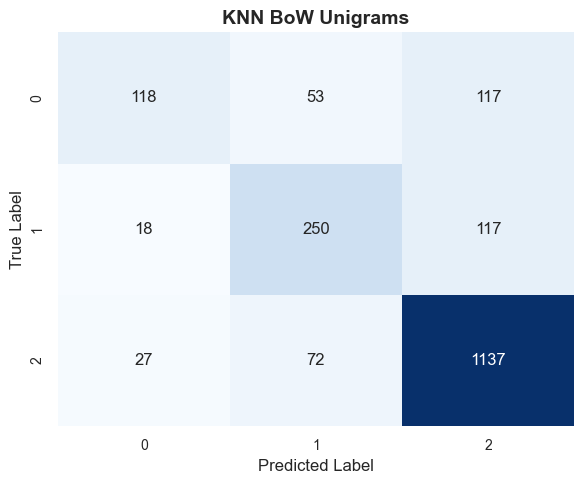

In [17]:
plot_confusion_matrix(y_val, y_val_pred_bow_unigrams, title=title, labels=[0, 1, 2], cmap="Blues")

### **2.1.2** Unigrams + Bigrams

In [18]:
modelknn = KNeighborsClassifier(n_neighbors = n_neighbors, metric = metric, weights = 'distance')

X_bow_bigrams, y_train_pred_bow_bigrams, y_val_pred_bow_bigrams, bow_bigrams = embedding_bow(x_train=x_train, y_train=y_train, x_val=x_val, model=modelknn, ngram_range=(1,2), oversampling_function=oversample)

KeyboardInterrupt: 

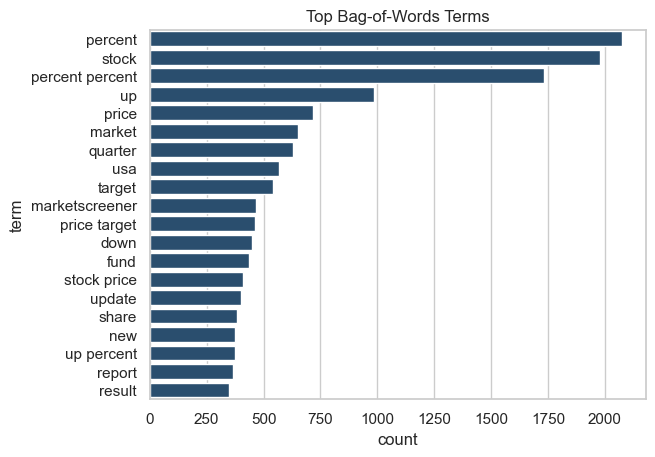

In [ ]:
clean_bow_sum = np.array(X_bow_bigrams.sum(axis=0)).flatten()
clean_terms = bow_bigrams.get_feature_names_out()
clean_top = pd.DataFrame({'term': clean_terms, 'count': clean_bow_sum}).sort_values(by='count', ascending=False).head(20)

sns.barplot(data=clean_top, x='count', y='term', color='#1f4e79')
plt.title("Top Bag-of-Words Terms")
plt.show()

In [ ]:
title = "KNN BoW Bigrams"

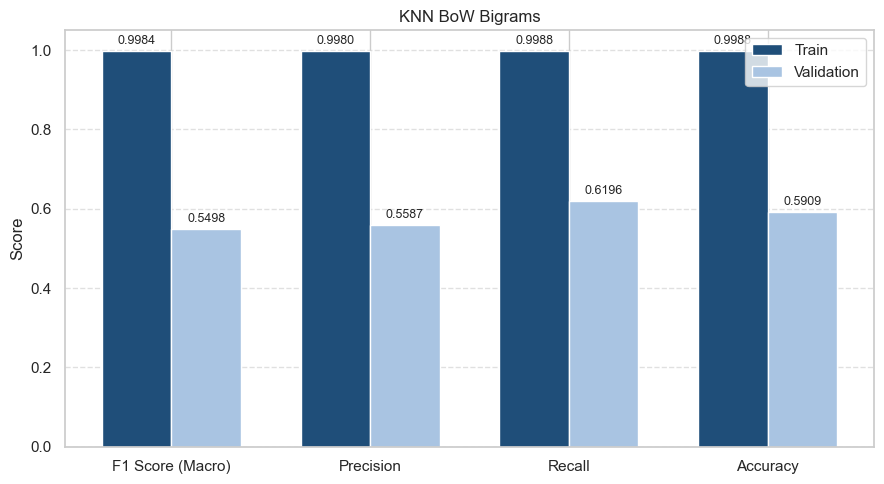

In [ ]:
metrics_df.append(get_metrics_df(title, y_train, y_train_pred_bow_bigrams, y_val, y_val_pred_bow_bigrams))

# Plot metrics
plot_metrics(y_train, y_train_pred_bow_bigrams, y_val, y_val_pred_bow_bigrams, title=title)

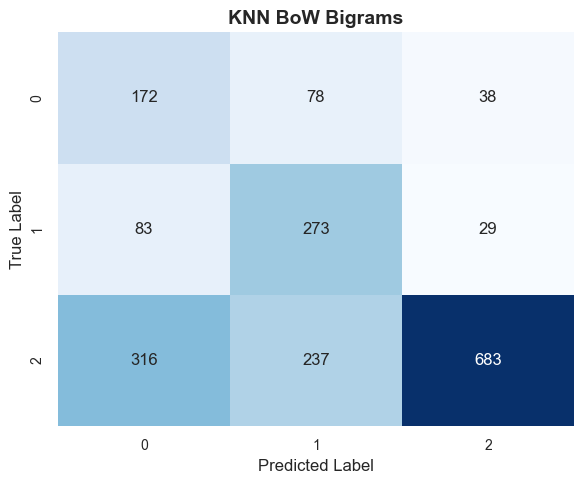

In [ ]:
plot_confusion_matrix(y_val, y_val_pred_bow_bigrams, title=title, labels=[0, 1, 2], cmap="Blues")

## **2.2** TF-IDF

### **2.2.1** Unigrams

In [ ]:
modelknn = KNeighborsClassifier(n_neighbors = n_neighbors, metric = metric, weights = weights)

X_tfidf_unigrams, y_train_pred_tfidf_unigrams, y_val_pred_tfidf_unigrams, tfidf_unigrams = embedding_tfidf(x_train=x_train, y_train=y_train, x_val=x_val, max_df=max_df, model=modelknn)

In [ ]:
tfidf_unigrams.get_feature_names_out()

array(['aa', 'aal', 'aaoi', ..., 'zyen', 'zynex', 'zynga'], dtype=object)

In [ ]:
tfidf_unigrams.vocabulary_

{'nasdaq': 6781,
 'price': 7940,
 'percent': 7551,
 'senior': 9099,
 'note': 7013,
 'future': 4199,
 'up': 12012,
 'november': 7030,
 'nonfarm': 6970,
 'private': 7965,
 'payroll': 7503,
 'consensus': 2243,
 'ticker_econx': 10815,
 'twitter': 11857,
 'user': 12059,
 'explain': 3718,
 'kohl': 5680,
 'stock': 9730,
 'got': 4433,
 'obliterated': 7101,
 'reporting': 8502,
 'earnings': 3232,
 'agilysys': 260,
 'restaurant': 8564,
 'find': 3932,
 'sustainable': 9946,
 'method': 6448,
 'limiting': 5945,
 'food': 4045,
 'waste': 12304,
 'holiday': 4818,
 'make': 6173,
 'retirement': 8592,
 'top': 11647,
 'ranked': 8236,
 'mutual': 6738,
 'fund': 4186,
 'february': 3858,
 'could': 2391,
 'applied': 590,
 'dna': 3045,
 'science': 8990,
 'inc': 5094,
 'apdn': 569,
 'see': 9059,
 'reversal': 8616,
 'breaking': 1377,
 'week': 12353,
 'low': 6074,
 'lamp': 5746,
 'news': 6884,
 'usmca': 12062,
 'affect': 225,
 'usa': 12051,
 'steelmaker': 9693,
 'auto': 818,
 'manufacturer': 6220,
 'manchester': 620

In [ ]:
# get the IDF score for each term
idf_dict = dict(zip(tfidf_unigrams.get_feature_names_out(), tfidf_unigrams.idf_))

# Get the first 10 items
idf_dict_10 = dict(list(idf_dict.items())[4100:4110])

print(idf_dict_10)

{'four': 6.995535198123193, 'fourth': 5.9509901307253585, 'fowl': 9.246826996729688, 'fox': 8.553679816169742, 'foxbusiness': 8.553679816169742, 'foxconn': 8.553679816169742, 'foxnews': 9.246826996729688, 'fpga': 9.246826996729688, 'fpp': 9.246826996729688, 'fpt': 9.246826996729688}


In [ ]:
title = "KNN TF-IDF Unigrams"

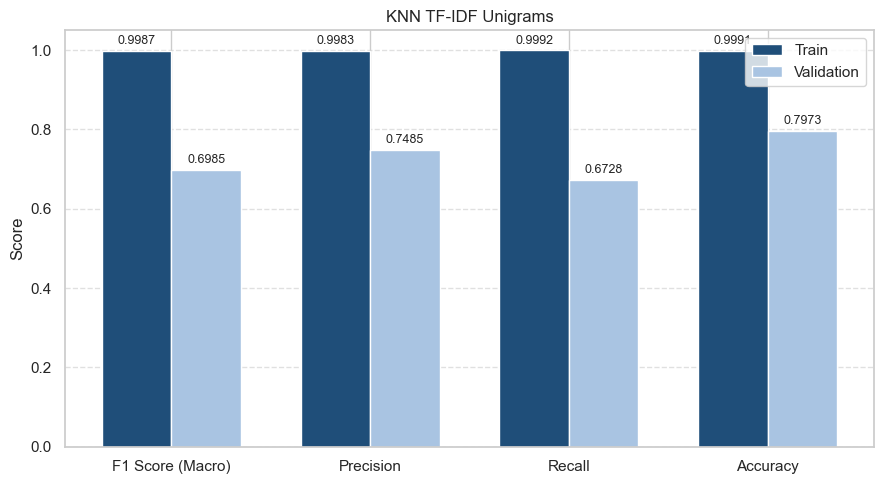

In [ ]:
metrics_df.append(get_metrics_df(title, y_train, y_train_pred_tfidf_unigrams, y_val, y_val_pred_tfidf_unigrams))

# Plot metrics
plot_metrics(y_train, y_train_pred_tfidf_unigrams, y_val, y_val_pred_tfidf_unigrams, title=title)

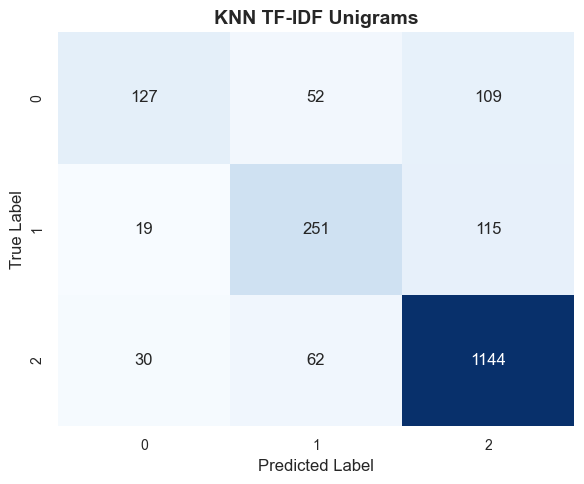

In [ ]:
plot_confusion_matrix(y_val, y_val_pred_tfidf_unigrams, title=title, labels=[0, 1, 2], cmap="Blues")

### **2.2.2** Bigrams

In [ ]:
modelknn = KNeighborsClassifier(n_neighbors = n_neighbors, metric = metric, weights = weights)

X_tfidf_bigrams, y_train_pred_tfidf_bigrams, y_val_pred_tfidf_bigrams, tfidf_bigrams = embedding_tfidf(x_train=x_train, y_train=y_train, x_val=x_val, max_df=max_df, model=modelknn, ngram_range=(1,2))

In [ ]:
tfidf_bigrams.get_feature_names_out()

array(['aa', 'aa cc', 'aal', ..., 'zynga', 'zynga nasdaq', 'zynga share'],
      dtype=object)

In [ ]:
tfidf_bigrams.vocabulary_

{'nasdaq': 31116,
 'price': 36807,
 'percent': 34740,
 'senior': 42616,
 'note': 32303,
 'nasdaq price': 31201,
 'price percent': 36870,
 'percent percent': 34908,
 'percent senior': 34950,
 'senior note': 42629,
 'future': 19130,
 'up': 52401,
 'future up': 19176,
 'november': 32386,
 'nonfarm': 32196,
 'private': 37013,
 'payroll': 34549,
 'consensus': 10005,
 'ticker_econx': 49004,
 'november nonfarm': 32399,
 'nonfarm private': 32198,
 'private payroll': 37023,
 'payroll consensus': 34550,
 'consensus ticker_econx': 10021,
 'twitter': 51771,
 'user': 53151,
 'explain': 16662,
 'kohl': 25824,
 'stock': 45403,
 'got': 20386,
 'obliterated': 32723,
 'reporting': 39606,
 'earnings': 14509,
 'twitter user': 51788,
 'user explain': 53154,
 'explain kohl': 16663,
 'kohl stock': 25835,
 'stock got': 45477,
 'got obliterated': 20389,
 'obliterated reporting': 32724,
 'reporting earnings': 39608,
 'agilysys': 927,
 'restaurant': 39887,
 'find': 17839,
 'sustainable': 46648,
 'method': 29606,

In [ ]:
# get the IDF score for each term
idf_dict = dict(zip(tfidf_bigrams.get_feature_names_out(), tfidf_bigrams.idf_))

# Get the first 10 items
idf_dict_10 = dict(list(idf_dict.items())[4100:4110])

print(idf_dict_10)

{'baxterinternational stock': 9.246826996729688, 'bayer': 8.330536264855532, 'bayer asks': 9.246826996729688, 'bayer face': 9.246826996729688, 'bayer plaintiff': 9.246826996729688, 'bayer seek': 9.246826996729688, 'bayer stock': 9.246826996729688, 'bayway': 9.246826996729688, 'bayway refinery': 9.246826996729688, 'bazooka': 8.841361888621524}


In [ ]:
title = "KNN TF-IDF Bigrams"

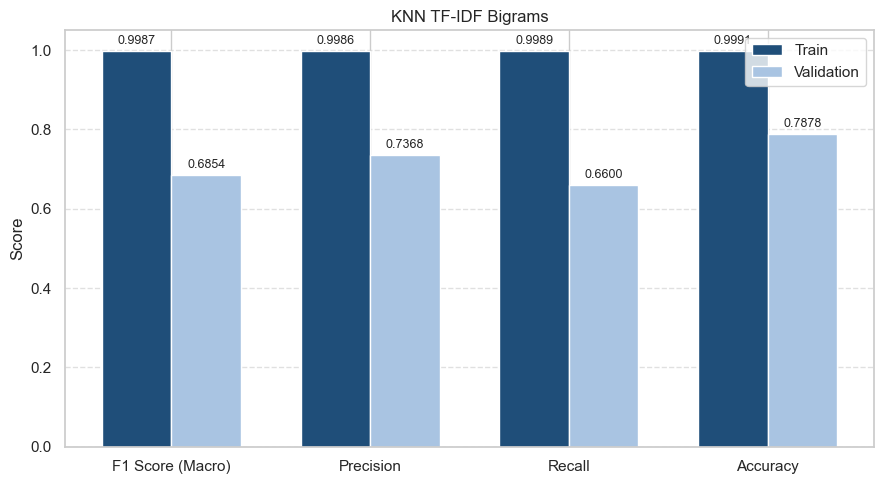

In [ ]:
metrics_df.append(get_metrics_df(title, y_train, y_train_pred_tfidf_bigrams, y_val, y_val_pred_tfidf_bigrams))

# Plot metrics
plot_metrics(y_train, y_train_pred_tfidf_bigrams, y_val, y_val_pred_tfidf_bigrams, title=title)

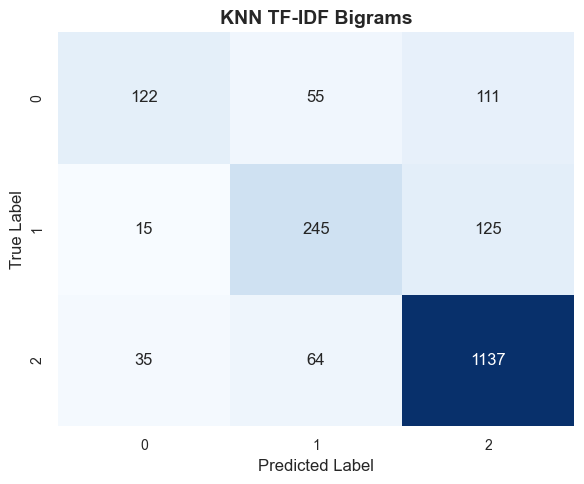

In [ ]:
plot_confusion_matrix(y_val, y_val_pred_tfidf_bigrams, title=title, labels=[0, 1, 2], cmap="Blues")

## **2.3** Word2Vec

### **2.3.1** Minimum count = 1

In [ ]:
modelknn = KNeighborsClassifier(n_neighbors = n_neighbors, metric = metric, weights = weights)

X_train_vec, y_train_pred_vec, y_val_pred_vec = embedding_word2vec(x_train=x_train, y_train=y_train, x_val=x_val, window=window, min_count=min_count, model=modelknn)

In [ ]:
title = "KNN Word2Vec"

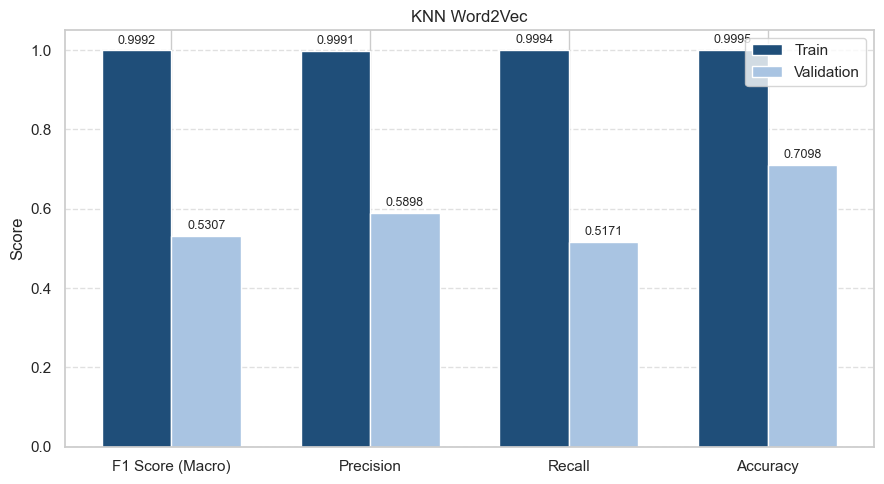

In [ ]:
metrics_df.append(get_metrics_df(title, y_train, y_train_pred_vec, y_val, y_val_pred_vec))

# Plot metrics
plot_metrics(y_train, y_train_pred_vec, y_val, y_val_pred_vec, title=title)

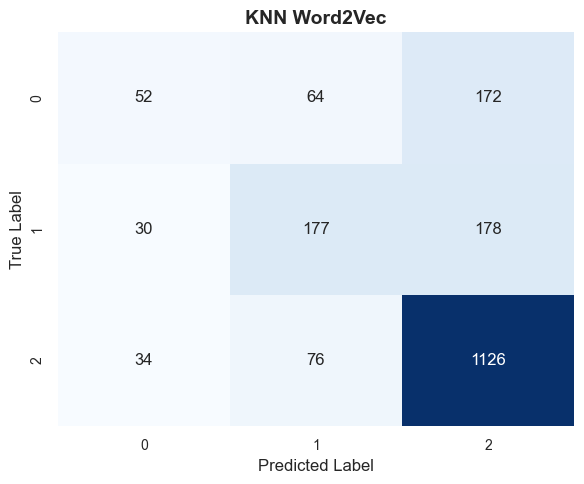

In [ ]:
plot_confusion_matrix(y_val, y_val_pred_vec, title=title, labels=[0, 1, 2], cmap="Blues")

### **2.3.2** Minimum count based on percentile

In [ ]:
tokenized_train = [word_tokenize(tweet.lower()) for tweet in x_train['text']]
all_tokens = [word for tweet in tokenized_train for word in tweet]

# frequency of each word
word_freq = Counter(all_tokens)
freq_values = np.array(list(word_freq.values()))

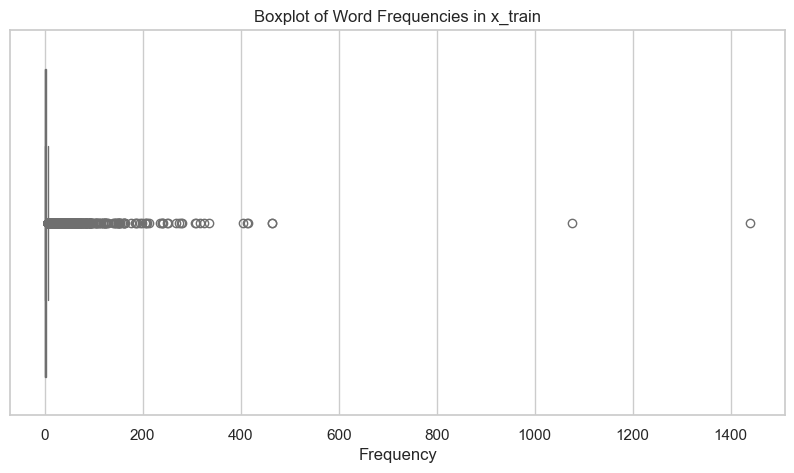

In [ ]:
# boxplot
plt.figure(figsize=(10, 5))
sns.boxplot(x=freq_values, color='skyblue')
plt.title("Boxplot of Word Frequencies in x_train")
plt.xlabel("Frequency")
plt.show()

In [ ]:
# 75th percentile
percentile_75 = int(np.percentile(freq_values, 75))

print(f"75th percentile: {percentile_75}")

75th percentile: 3


In [ ]:
modelknn = KNeighborsClassifier(n_neighbors = n_neighbors, metric = metric, weights = weights)

X_train_vec, y_train_pred_vec, y_val_pred_vec = embedding_word2vec(x_train=x_train, y_train=y_train, x_val=x_val, window=window, min_count=percentile_75, model=modelknn)

In [ ]:
title = "KNN Word2Vec - Min count = 75th percentile"

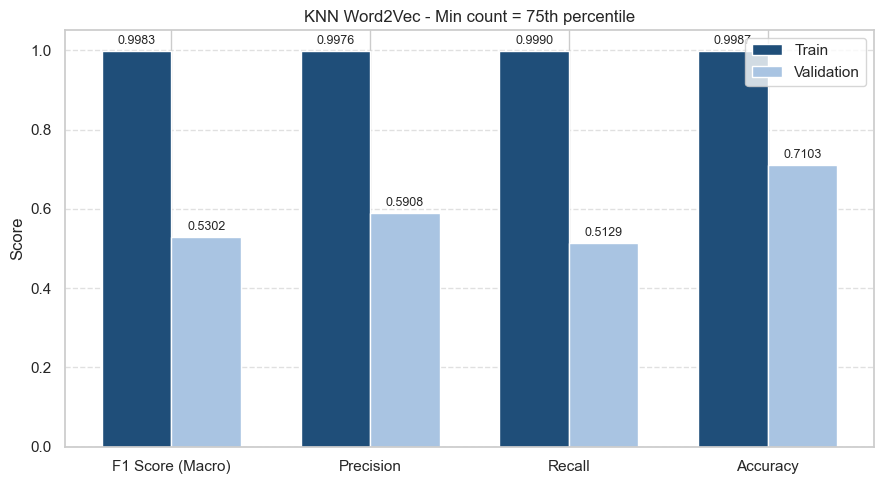

In [ ]:
metrics_df.append(get_metrics_df(title, y_train, y_train_pred_vec, y_val, y_val_pred_vec))

# Plot metrics
plot_metrics(y_train, y_train_pred_vec, y_val, y_val_pred_vec, title=title)

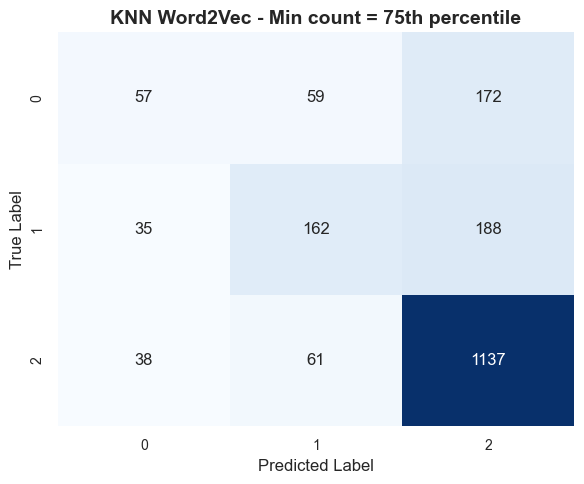

In [ ]:
plot_confusion_matrix(y_val, y_val_pred_vec, title=title, labels=[0, 1, 2], cmap="Blues")

In [ ]:
metrics_df

,Model,Train F1 (Macro),Val F1 (Macro),Train Precision,Val Precision,Train Recall,Val Recall,Train Accuracy,Val Accuracy
0,KNN BoW Unigrams,0.9987,0.6845,0.9989,0.7400,0.9986,0.6597,0.9991,0.7884
1,KNN BoW Bigrams,0.9984,0.5498,0.9980,0.5587,0.9988,0.6196,0.9988,0.5909
2,KNN TF-IDF Unigrams,0.9987,0.6985,0.9983,0.7485,0.9992,0.6728,0.9991,0.7973
3,KNN TF-IDF Bigrams,0.9987,0.6854,0.9986,0.7368,0.9989,0.6600,0.9991,0.7878
4,KNN Word2Vec,0.9992,0.5307,0.9991,0.5898,0.9994,0.5171,0.9995,0.7098
5,KNN Word2Vec - Min count = 75th percentile,0.9983,0.5302,0.9976,0.5908,0.9990,0.5129,0.9987,0.7103


## **2.4** Glove

In [ ]:
modelknn = KNeighborsClassifier(n_neighbors = n_neighbors, metric = metric, weights = weights)

X_train_glove_avg, y_train_pred_glove, y_val_pred_glove = embedding_glove(x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val, model_glove = glove_model, emb_size=emb_size)

100%|██████████| 1909/1909 [00:00<00:00, 15304.46it/s]


KeyError: 'label'

In [ ]:
title = "KNN Glove"

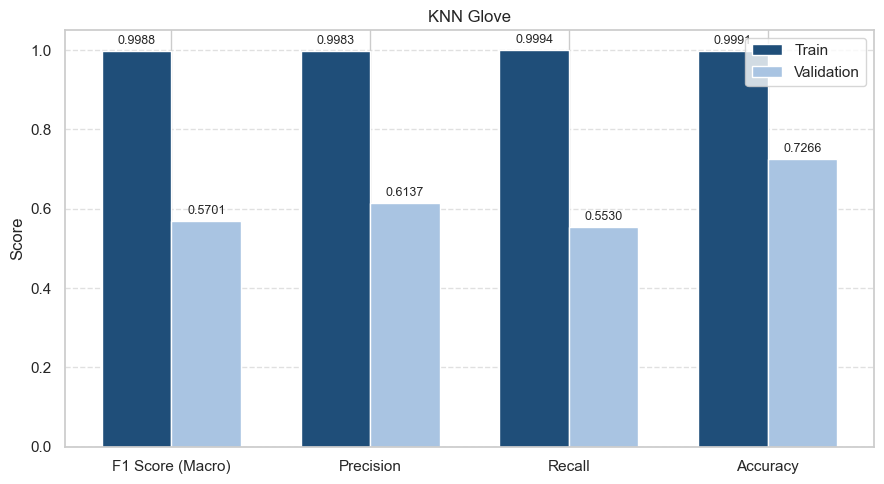

In [ ]:
metrics_df.append(get_metrics_df(title, y_train, y_train_pred_glove, y_val, y_val_pred_glove))

# Plot metrics
plot_metrics(y_train, y_train_pred_glove, y_val, y_val_pred_glove, title=title)

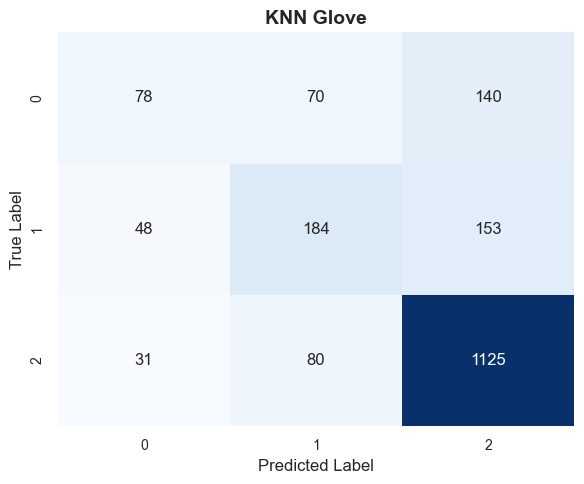

In [ ]:
plot_confusion_matrix(y_val, y_val_pred_glove, title=title, labels=[0, 1, 2], cmap="Blues")

## **2.5** Text Embedding 3 Small - EXTRA

In [ ]:
modelknn = KNeighborsClassifier(n_neighbors = n_neighbors, metric = metric, weights = weights)

X_train_te3s, y_train_pred_te3s,y_val_pred_te3s = embedding_te3s(train_texts=train_texts,
                                                                 train_labels=train_labels,
                                                                 val_texts = val_texts, 
                                                                 cache_file_train="X_train_te3s_embeddings.pkl", 
                                                                 cache_file_val="X_val_te3s_embeddings.pkl",
                                                                 client=client,
                                                                 model_te3s=model_te3s,
                                                                 batch_size=32,
                                                                 model=modelknn)

Loading embeddings from X_train_te3s_embeddings.pkl...
Loading embeddings from X_val_te3s_embeddings.pkl...


In [ ]:
# Define the title for the metrics and plots
title = "KNN with Text Embedding 3 Small"

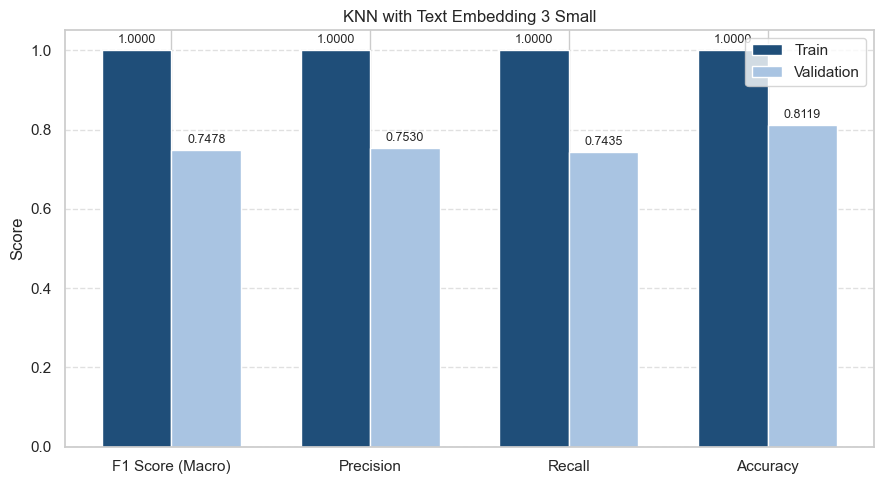

In [ ]:
# Get metrics DataFrame
metrics_df.append(get_metrics_df(title, train_labels, y_train_pred_te3s, val_labels, y_val_pred_te3s))
metrics_df

# Plot metrics
plot_metrics(train_labels, y_train_pred_te3s, val_labels, y_val_pred_te3s, title=title)

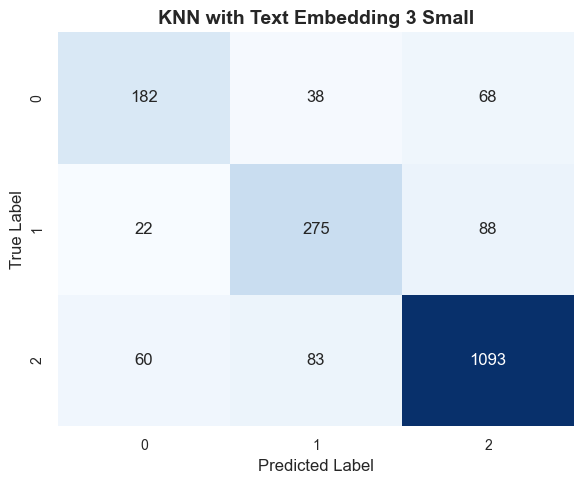

In [ ]:
# Plot confusion matrix
plot_confusion_matrix(val_labels, y_val_pred_te3s, title=title, labels=[0, 1, 2], cmap="Blues")

## **2.6** Twitter Roberta Base - EXTRA

In [ ]:
modelknn = KNeighborsClassifier(n_neighbors = n_neighbors, metric = metric, weights = weights)

X_train_roberta, y_train_pred_roberta,y_val_pred_roberta = embedding_roberta(train_texts=train_texts,
                                                                 train_labels=train_labels,
                                                                 val_texts = val_texts, 
                                                                 cache_file_train="X_train_te3s_embeddings.pkl", 
                                                                 cache_file_val="X_val_te3s_embeddings.pkl",
                                                                 tokenizer_roberta=tokenizer_roberta,
                                                                 model_roberta=model_roberta,
                                                                 batch_size=32,
                                                                 model=modelknn)

Loading RoBERTa embeddings from X_train_te3s_embeddings.pkl...
Loading RoBERTa embeddings from X_val_te3s_embeddings.pkl...


In [ ]:
# Define the title for the metrics and plots
title = "KNN with RoBERTa"

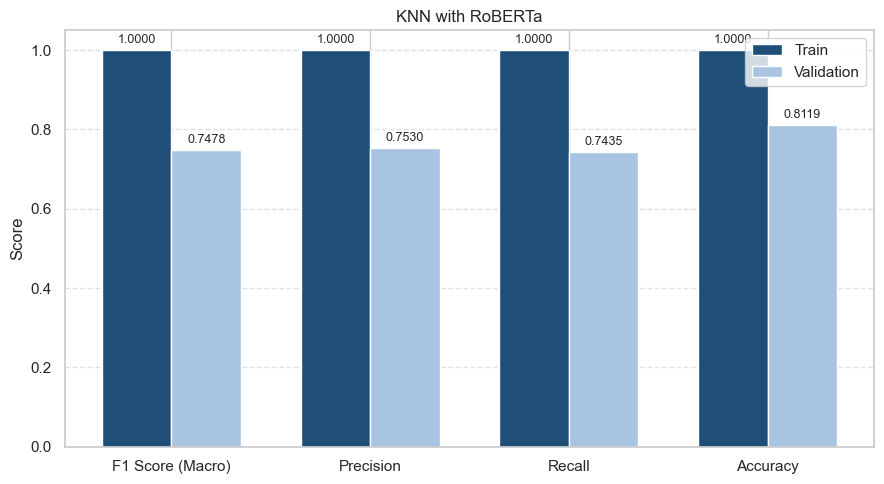

In [ ]:
# Get metrics DataFrame
metrics_df.append(get_metrics_df(title, train_labels, y_train_pred_roberta, val_labels, y_val_pred_roberta))
metrics_df

# Plot metrics
plot_metrics(train_labels, y_train_pred_roberta, val_labels, y_val_pred_roberta, title=title)

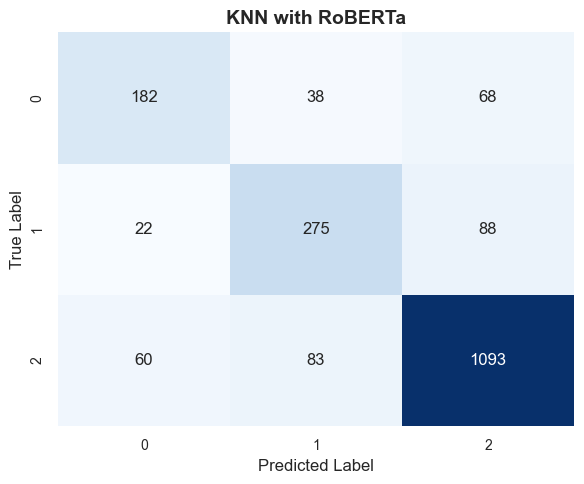

In [ ]:
# Plot confusion matrix
plot_confusion_matrix(val_labels, y_val_pred_roberta, title=title, labels=[0, 1, 2], cmap="Blues")

<div class="alert alert-block alert-success">

# **3.** **Naive Bayes**

<div>

We didn't use Word2Vec, Glove or Extra because they generate numbers that can be negative and Naive Bayes is based on probabilities and word frequencies, which must be non-negative — negative values don’t make sense in this context and would cause errors during training.

## **3.1** Bag of Words

### **3.1.1** Unigrams

In [ ]:
model_nb = MultinomialNB(alpha=alpha)

# each term is marked as present or not per document - good for short text
X_bow_unigrams, y_train_pred_bow_unigrams, y_val_pred_bow_unigrams, bow_unigrams = embedding_bow(x_train=x_train, y_train=y_train, x_val=x_val, model=model_nb)

In [ ]:
title = "Naive Bayes BoW Unigrams"

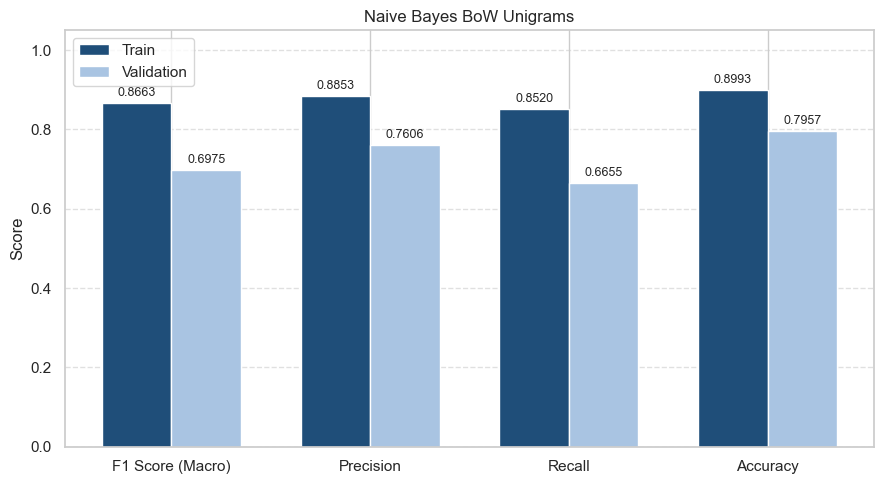

In [ ]:
metrics_df.append(get_metrics_df(title, y_train, y_train_pred_bow_unigrams, y_val, y_val_pred_bow_unigrams))

# Plot metrics
plot_metrics(y_train, y_train_pred_bow_unigrams, y_val, y_val_pred_bow_unigrams, title=title)

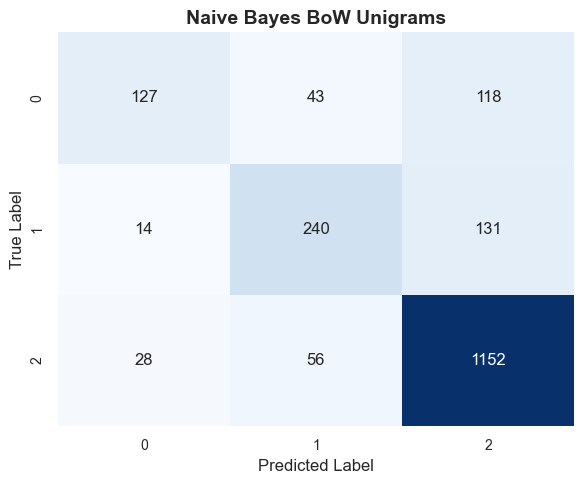

In [ ]:
plot_confusion_matrix(y_val, y_val_pred_bow_unigrams, title=title, labels=[0, 1, 2], cmap="Blues")

### **3.1.2** Unigrams + Bigrams

In [ ]:
model_nb = MultinomialNB(alpha=alpha)

X_bow_bigrams, y_train_pred_bow_bigrams, y_val_pred_bow_bigrams, bow_bigrams = embedding_bow(x_train=x_train, y_train=y_train, x_val=x_val, model=model_nb, ngram_range=(1,2))

In [ ]:
title = "Naive Bayes BoW Bigrams"

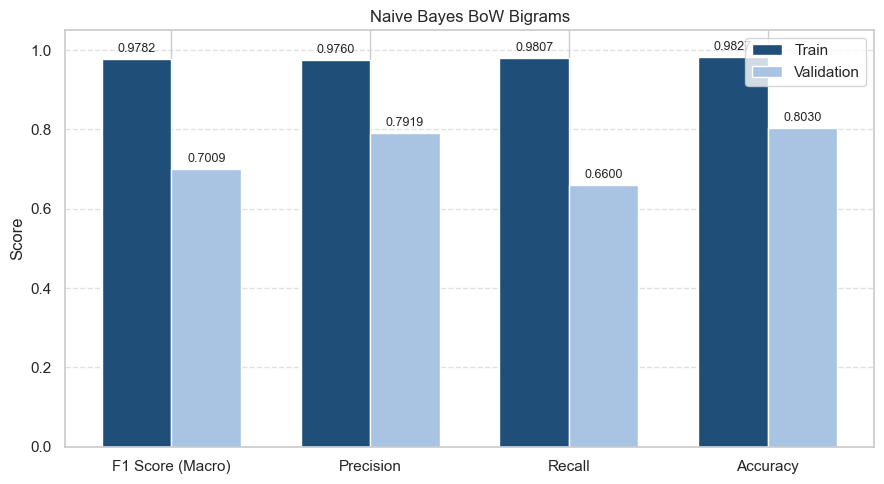

In [ ]:
metrics_df.append(get_metrics_df(title, y_train, y_train_pred_bow_bigrams, y_val, y_val_pred_bow_bigrams))

# Plot metrics
plot_metrics(y_train, y_train_pred_bow_bigrams, y_val, y_val_pred_bow_bigrams, title=title)

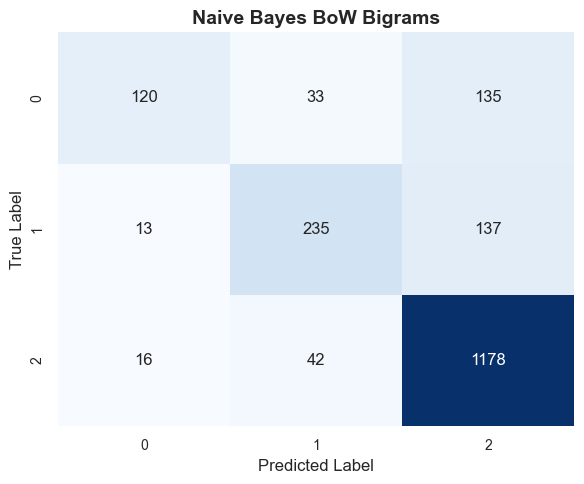

In [ ]:
plot_confusion_matrix(y_val, y_val_pred_bow_bigrams, title=title, labels=[0, 1, 2], cmap="Blues")

## **3.2** TF-IDF

### **3.2.1** Unigrams

In [ ]:
model_nb = MultinomialNB(alpha=alpha)

X_tfidf_unigrams, y_train_pred_tfidf_unigrams, y_val_pred_tfidf_unigrams, tfidf_unigrams = embedding_tfidf(x_train=x_train, y_train=y_train, x_val=x_val, max_df=max_df, model=model_nb)

In [ ]:
title = "Naive Bayes TF-IDF Unigrams"

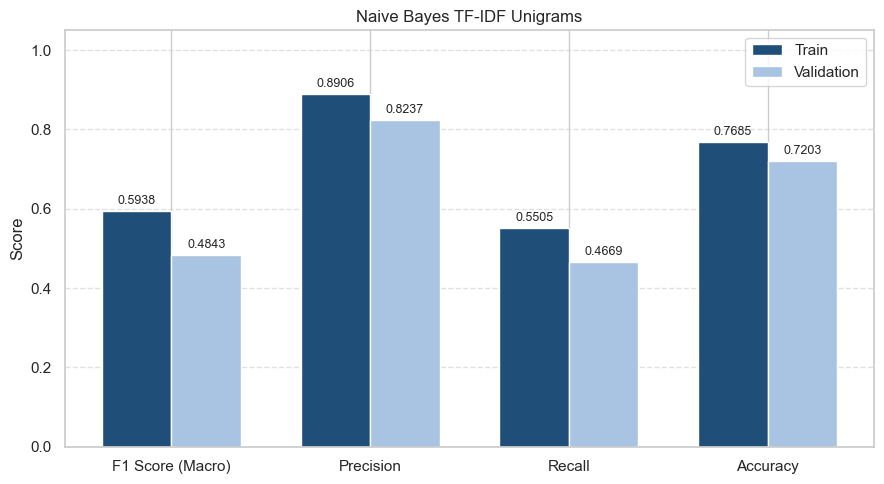

In [ ]:
metrics_df.append(get_metrics_df(title, y_train, y_train_pred_tfidf_unigrams, y_val, y_val_pred_tfidf_unigrams))

# Plot metrics
plot_metrics(y_train, y_train_pred_tfidf_unigrams, y_val, y_val_pred_tfidf_unigrams, title=title)

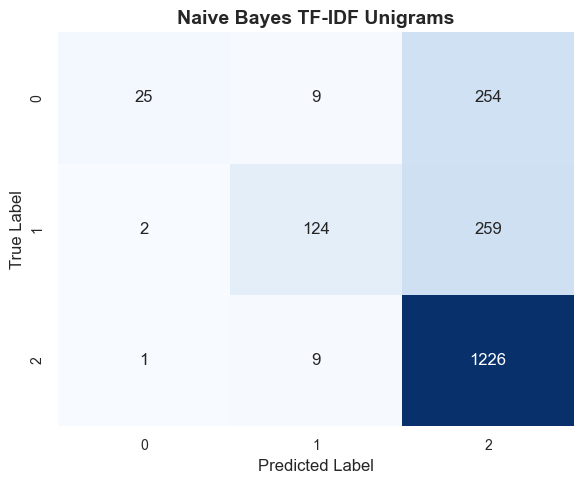

In [ ]:
plot_confusion_matrix(y_val, y_val_pred_tfidf_unigrams, title=title, labels=[0, 1, 2], cmap="Blues")

### **3.2.2** Bigrams

In [ ]:
model_nb = MultinomialNB(alpha=alpha)

X_tfidf_bigrams, y_train_pred_tfidf_bigrams, y_val_pred_tfidf_bigrams, tfidf_bigrams = embedding_tfidf(x_train=x_train, y_train=y_train, x_val=x_val, max_df=max_df, model=model_nb, ngram_range=(1,2))

In [ ]:
title = "Naive Bayes TF-IDF Bigrams"

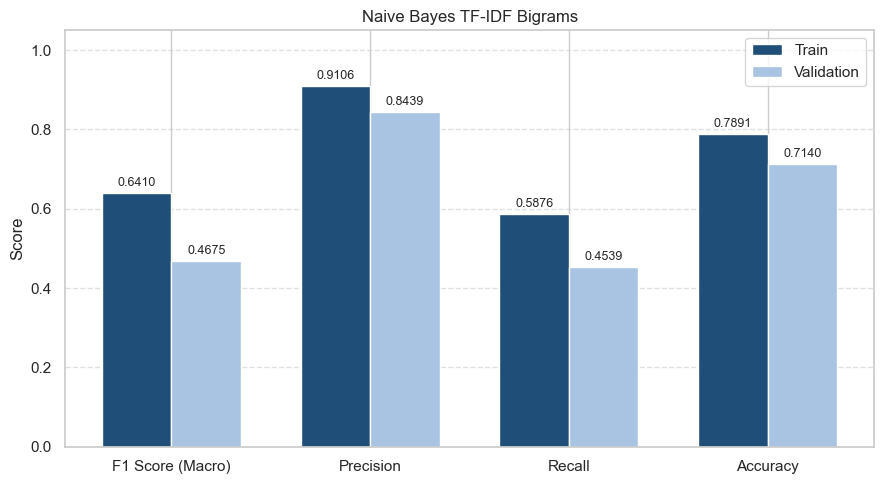

In [ ]:
metrics_df.append(get_metrics_df(title, y_train, y_train_pred_tfidf_bigrams, y_val, y_val_pred_tfidf_bigrams))

# Plot metrics
plot_metrics(y_train, y_train_pred_tfidf_bigrams, y_val, y_val_pred_tfidf_bigrams, title=title)

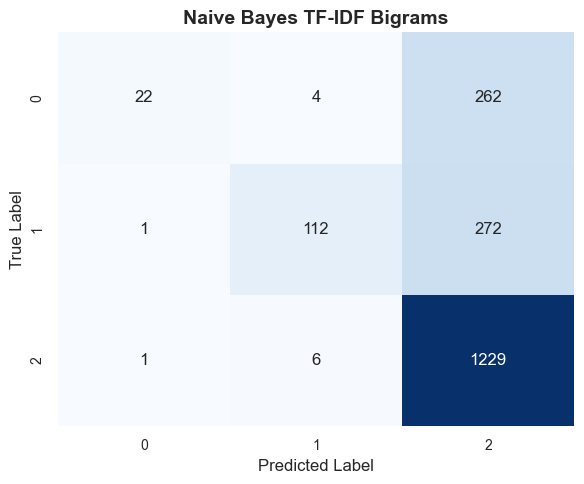

In [ ]:
plot_confusion_matrix(y_val, y_val_pred_tfidf_bigrams, title=title, labels=[0, 1, 2], cmap="Blues")

<div class="alert alert-block alert-success">

# **4.** **Random Forest**

<div>

## **4.1** Bag of Words

### **4.1.1** Unigrams

In [ ]:
model_rf = RandomForestClassifier(
    n_estimators=n_estimators,          
    criterion=criterion,         
    max_depth=max_depth,          
    min_samples_split=min_samples_split,      
    min_samples_leaf=min_samples_leaf,      
    max_features=max_features,
    class_weight=class_weight    
)

X_bow_unigrams, y_train_pred_bow_unigrams, y_val_pred_bow_unigrams, bow_unigrams = embedding_bow(x_train=x_train, y_train=y_train, x_val=x_val, model=model_rf)

In [ ]:
title = "Random Forest BoW Unigrams"

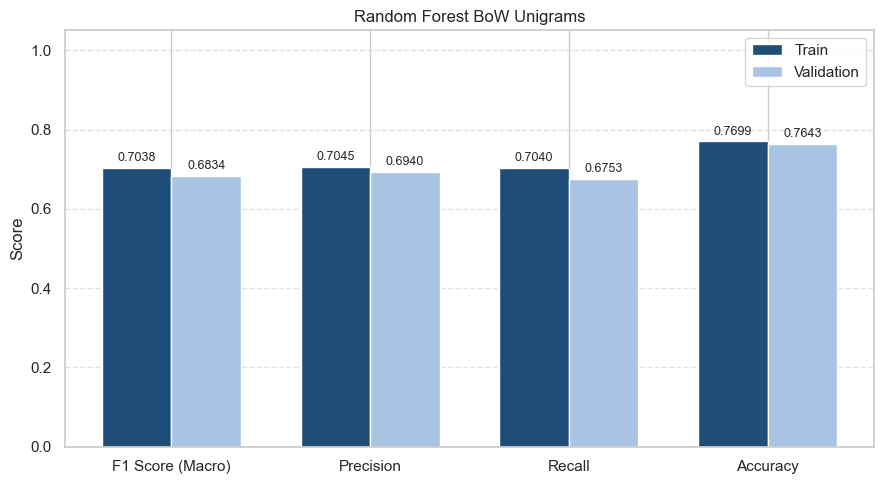

In [ ]:
metrics_df.append(get_metrics_df(title, y_train, y_train_pred_bow_unigrams, y_val, y_val_pred_bow_unigrams))

# Plot metrics
plot_metrics(y_train, y_train_pred_bow_unigrams, y_val, y_val_pred_bow_unigrams, title=title)

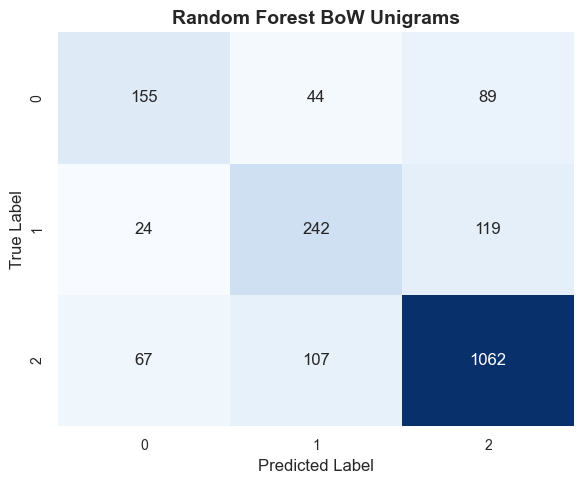

In [ ]:
plot_confusion_matrix(y_val, y_val_pred_bow_unigrams, title=title, labels=[0, 1, 2], cmap="Blues")

### **4.1.2** Unigrams + Bigrams

In [ ]:
model_rf = RandomForestClassifier(
    n_estimators=n_estimators,          
    criterion=criterion,         
    max_depth=max_depth,          
    min_samples_split=min_samples_split,      
    min_samples_leaf=min_samples_leaf,      
    max_features=max_features,
    class_weight=class_weight    
)

X_bow_bigrams, y_train_pred_bow_bigrams, y_val_pred_bow_bigrams, bow_bigrams = embedding_bow(x_train=x_train, y_train=y_train, x_val=x_val, model=model_rf, ngram_range=(1,2))

In [ ]:
title = "Random Forest BoW Bigrams"

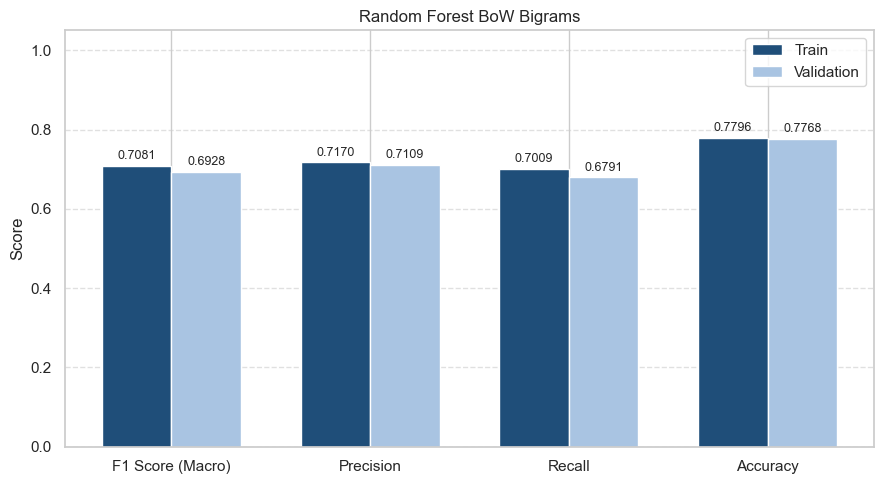

In [ ]:
metrics_df.append(get_metrics_df(title, y_train, y_train_pred_bow_bigrams, y_val, y_val_pred_bow_bigrams))

# Plot metrics
plot_metrics(y_train, y_train_pred_bow_bigrams, y_val, y_val_pred_bow_bigrams, title=title)

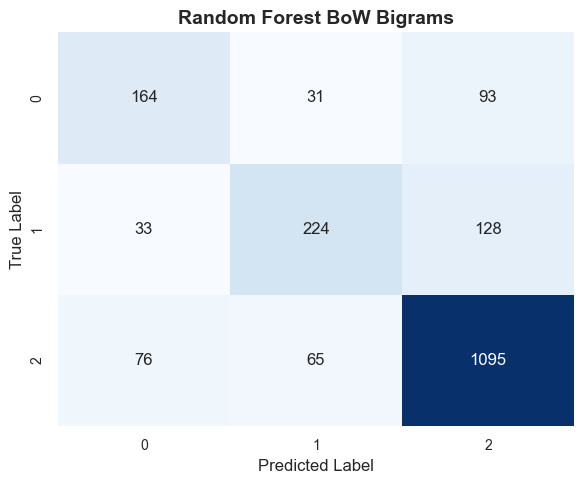

In [ ]:
plot_confusion_matrix(y_val, y_val_pred_bow_bigrams, title=title, labels=[0, 1, 2], cmap="Blues")

## **4.2** TF-IDF

### **4.2.1** Unigrams

In [ ]:
model_rf = RandomForestClassifier(
    n_estimators=n_estimators,          
    criterion=criterion,         
    max_depth=max_depth,          
    min_samples_split=min_samples_split,      
    min_samples_leaf=min_samples_leaf,      
    max_features=max_features,
    class_weight=class_weight    
)

X_tfidf_unigrams, y_train_pred_tfidf_unigrams, y_val_pred_tfidf_unigrams, tfidf_unigrams = embedding_tfidf(x_train=x_train, y_train=y_train, x_val=x_val, max_df=max_df, model=model_rf)

In [ ]:
title = "Random Forest TF-IDF Unigrams"

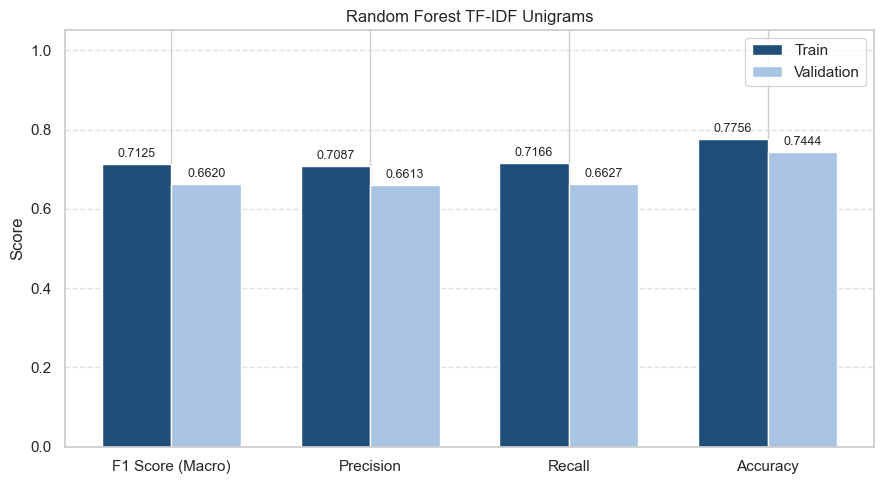

In [ ]:
metrics_df.append(get_metrics_df(title, y_train, y_train_pred_tfidf_unigrams, y_val, y_val_pred_tfidf_unigrams))

# Plot metrics
plot_metrics(y_train, y_train_pred_tfidf_unigrams, y_val, y_val_pred_tfidf_unigrams, title=title)

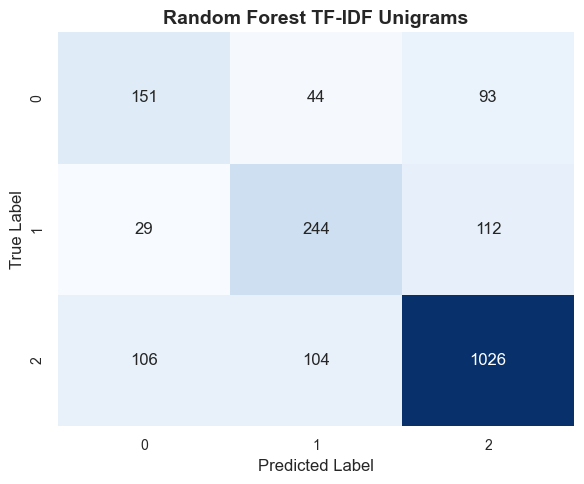

In [ ]:
plot_confusion_matrix(y_val, y_val_pred_tfidf_unigrams, title=title, labels=[0, 1, 2], cmap="Blues")

### **4.2.2** Bigrams

In [ ]:
model_rf = RandomForestClassifier(
    n_estimators=n_estimators,          
    criterion=criterion,         
    max_depth=max_depth,          
    min_samples_split=min_samples_split,      
    min_samples_leaf=min_samples_leaf,      
    max_features=max_features,
    class_weight=class_weight    
)

X_tfidf_bigrams, y_train_pred_tfidf_bigrams, y_val_pred_tfidf_bigrams, tfidf_bigrams = embedding_tfidf(x_train=x_train, y_train=y_train, x_val=x_val, max_df=max_df, model=model_rf, ngram_range=(1,2))

In [ ]:
title = "Random Forest TF-IDF Bigrams"

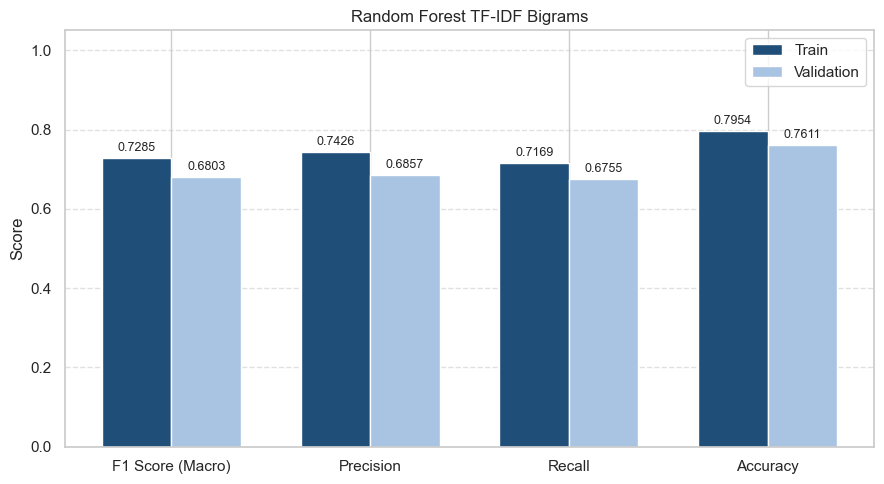

In [ ]:
metrics_df.append(get_metrics_df(title, y_train, y_train_pred_tfidf_bigrams, y_val, y_val_pred_tfidf_bigrams))

# Plot metrics
plot_metrics(y_train, y_train_pred_tfidf_bigrams, y_val, y_val_pred_tfidf_bigrams, title=title)

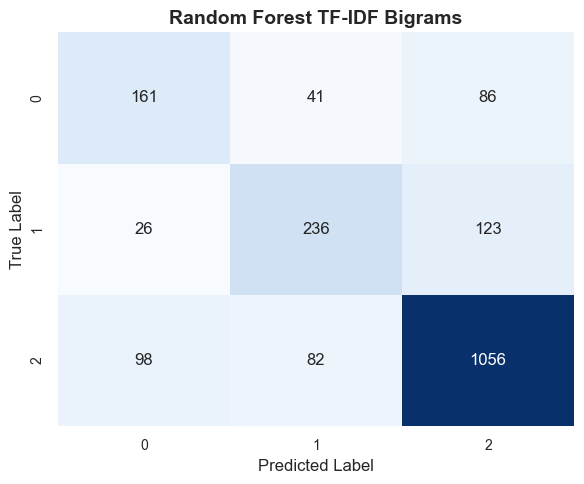

In [ ]:
plot_confusion_matrix(y_val, y_val_pred_tfidf_bigrams, title=title, labels=[0, 1, 2], cmap="Blues")

## **4.3** Word2Vec

### **4.3.1** Minimum count = 1

In [ ]:
model_rf = RandomForestClassifier(
    n_estimators=n_estimators,          
    criterion=criterion,         
    max_depth=max_depth,          
    min_samples_split=min_samples_split,      
    min_samples_leaf=min_samples_leaf,      
    max_features=max_features,
    class_weight=class_weight    
)

X_train_vec, y_train_pred_vec, y_val_pred_vec = embedding_word2vec(x_train=x_train, y_train=y_train, x_val=x_val, window=window, min_count=min_count, model=model_rf)

In [ ]:
title = "Random Forest Word2Vec"

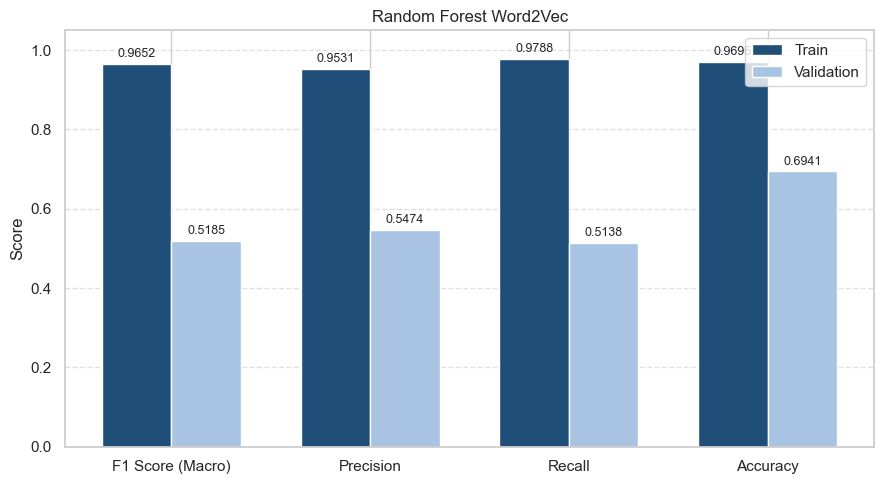

In [ ]:
metrics_df.append(get_metrics_df(title, y_train, y_train_pred_vec, y_val, y_val_pred_vec))

# Plot metrics
plot_metrics(y_train, y_train_pred_vec, y_val, y_val_pred_vec, title=title)

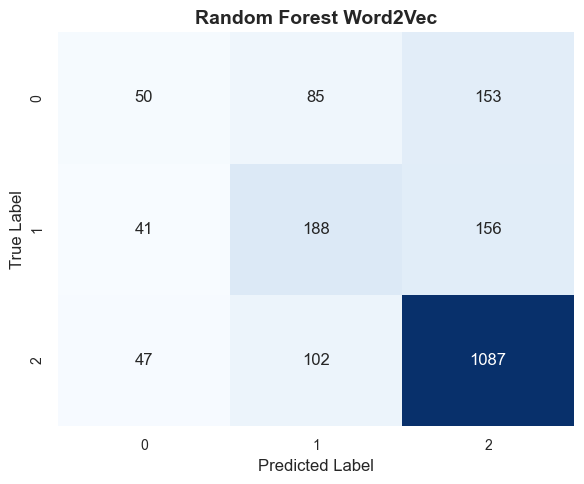

In [ ]:
plot_confusion_matrix(y_val, y_val_pred_vec, title=title, labels=[0, 1, 2], cmap="Blues")

### **4.3.2** Minimum count based on percentile

In [ ]:
model_rf = RandomForestClassifier(
    n_estimators=n_estimators,          
    criterion=criterion,         
    max_depth=max_depth,          
    min_samples_split=min_samples_split,      
    min_samples_leaf=min_samples_leaf,      
    max_features=max_features,
    class_weight=class_weight    
)

X_train_vec, y_train_pred_vec, y_val_pred_vec = embedding_word2vec(x_train=x_train, y_train=y_train, x_val=x_val, window=window, min_count=percentile_75, model=model_rf)

In [ ]:
title = "Random Forest Word2Vec - Min count = 75th percentile"

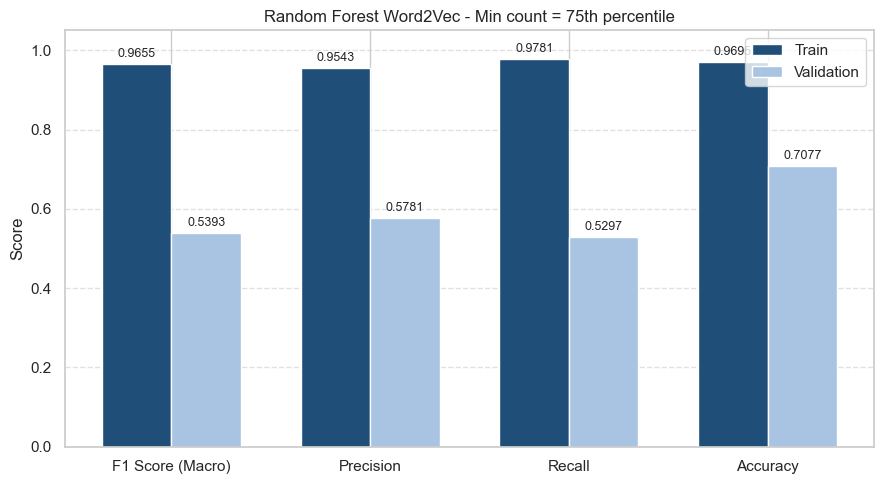

In [ ]:
metrics_df.append(get_metrics_df(title, y_train, y_train_pred_vec, y_val, y_val_pred_vec))

# Plot metrics
plot_metrics(y_train, y_train_pred_vec, y_val, y_val_pred_vec, title=title)

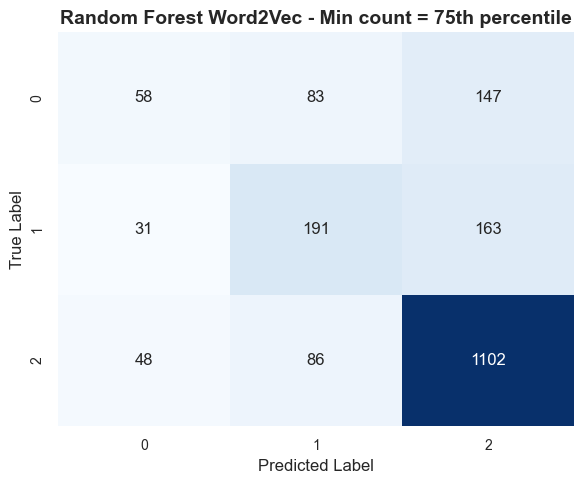

In [ ]:
plot_confusion_matrix(y_val, y_val_pred_vec, title=title, labels=[0, 1, 2], cmap="Blues")

## **4.4** Glove

In [ ]:
model_rf = RandomForestClassifier(
    n_estimators=n_estimators,          
    criterion=criterion,         
    max_depth=max_depth,          
    min_samples_split=min_samples_split,      
    min_samples_leaf=min_samples_leaf,      
    max_features=max_features,
    class_weight=class_weight    
)

X_train_glove_avg, y_train_pred_glove, y_val_pred_glove = embedding_glove(x_train=x_train, y_train=y_train, x_val=x_val, model_glove = glove_model, emb_size=emb_size, model=model_rf)

100%|██████████| 1909/1909 [00:00<00:00, 4596.60it/s]


In [ ]:
title = "Random Forest Glove"

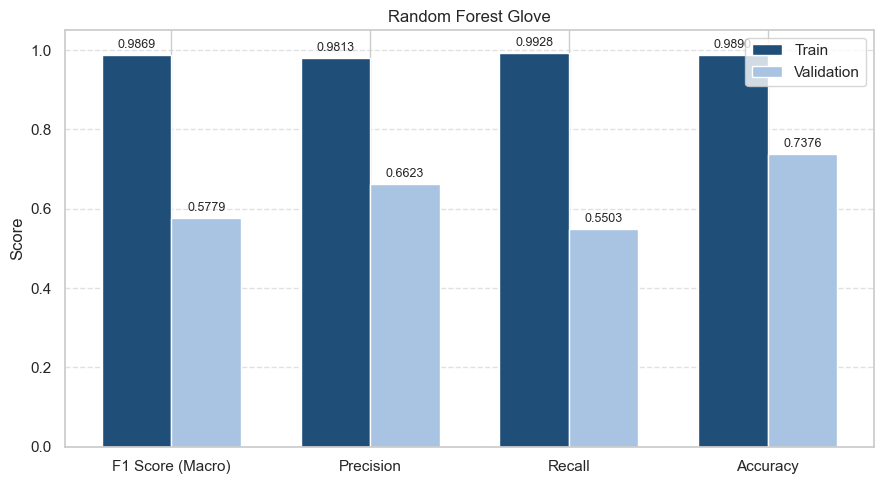

In [ ]:
metrics_df.append(get_metrics_df(title, y_train, y_train_pred_glove, y_val, y_val_pred_glove))

# Plot metrics
plot_metrics(y_train, y_train_pred_glove, y_val, y_val_pred_glove, title=title)

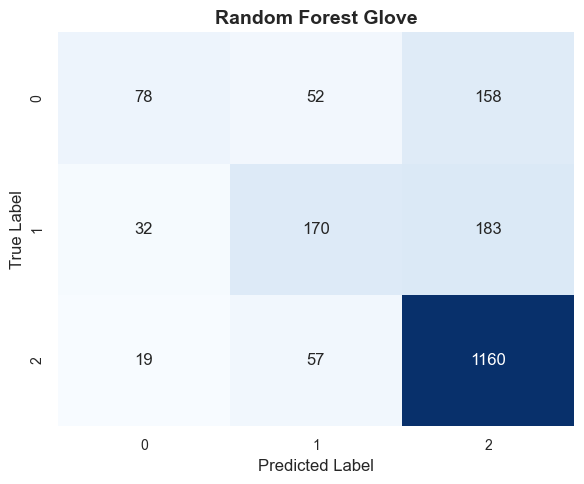

In [ ]:
plot_confusion_matrix(y_val, y_val_pred_glove, title=title, labels=[0, 1, 2], cmap="Blues")

## **4.5** Text Embedding 3 Small - EXTRA

In [ ]:
model_rf = RandomForestClassifier(
    n_estimators=n_estimators,          
    criterion=criterion,         
    max_depth=max_depth,          
    min_samples_split=min_samples_split,      
    min_samples_leaf=min_samples_leaf,      
    max_features=max_features,
    class_weight=class_weight    
)

X_train_te3s, y_train_pred_te3s,y_val_pred_te3s = embedding_te3s(train_texts=train_texts,
                                                                 train_labels=train_labels,
                                                                 val_texts = val_texts, 
                                                                 cache_file_train="X_train_te3s_embeddings.pkl", 
                                                                 cache_file_val="X_val_te3s_embeddings.pkl",
                                                                 client=client,
                                                                 model_te3s=model_te3s,
                                                                 batch_size=32,
                                                                 model=model_rf)

Loading embeddings from X_train_te3s_embeddings.pkl...
Loading embeddings from X_val_te3s_embeddings.pkl...


In [ ]:
# Define the title for the metrics and plots
title = "Random Forest with Text Embedding 3 Small"

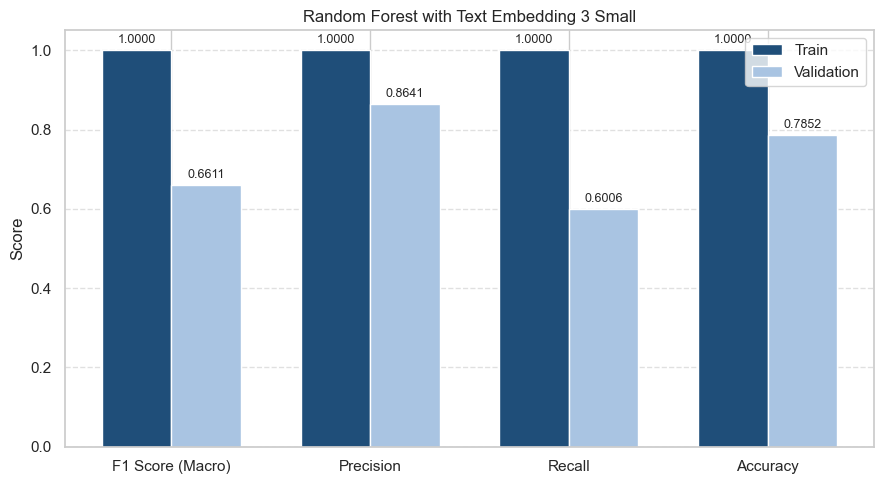

In [ ]:
# Get metrics DataFrame
metrics_df.append(get_metrics_df(title, train_labels, y_train_pred_te3s, val_labels, y_val_pred_te3s))
metrics_df

# Plot metrics
plot_metrics(train_labels, y_train_pred_te3s, val_labels, y_val_pred_te3s, title=title)

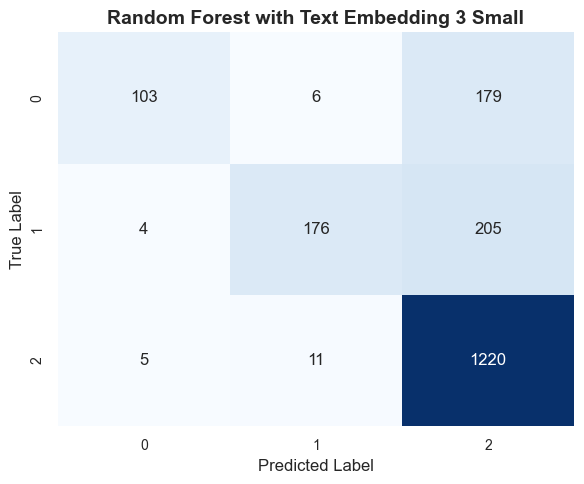

In [ ]:
# Plot confusion matrix
plot_confusion_matrix(val_labels, y_val_pred_te3s, title=title, labels=[0, 1, 2], cmap="Blues")

## **4.6** Twitter Roberta Base - EXTRA

In [ ]:
model_rf = RandomForestClassifier(
    n_estimators=n_estimators,          
    criterion=criterion,         
    max_depth=max_depth,          
    min_samples_split=min_samples_split,      
    min_samples_leaf=min_samples_leaf,      
    max_features=max_features,
    class_weight=class_weight    
)

X_train_roberta, y_train_pred_roberta,y_val_pred_roberta = embedding_roberta(train_texts=train_texts,
                                                                 train_labels=train_labels,
                                                                 val_texts = val_texts, 
                                                                 cache_file_train="X_train_te3s_embeddings.pkl", 
                                                                 cache_file_val="X_val_te3s_embeddings.pkl",
                                                                 tokenizer_roberta=tokenizer_roberta,
                                                                 model_roberta=model_roberta,
                                                                 batch_size=32,
                                                                 model=model_rf)

Loading RoBERTa embeddings from X_train_te3s_embeddings.pkl...
Loading RoBERTa embeddings from X_val_te3s_embeddings.pkl...


In [ ]:
# Define the title for the metrics and plots
title = "Random Forest with RoBERTa"

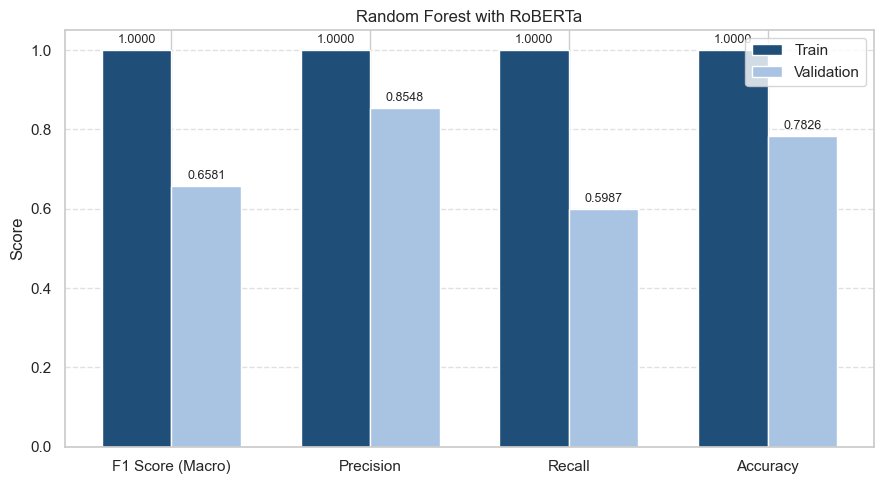

In [ ]:
# Get metrics DataFrame
metrics_df.append(get_metrics_df(title, train_labels, y_train_pred_roberta, val_labels, y_val_pred_roberta))
metrics_df

# Plot metrics
plot_metrics(train_labels, y_train_pred_roberta, val_labels, y_val_pred_roberta, title=title)

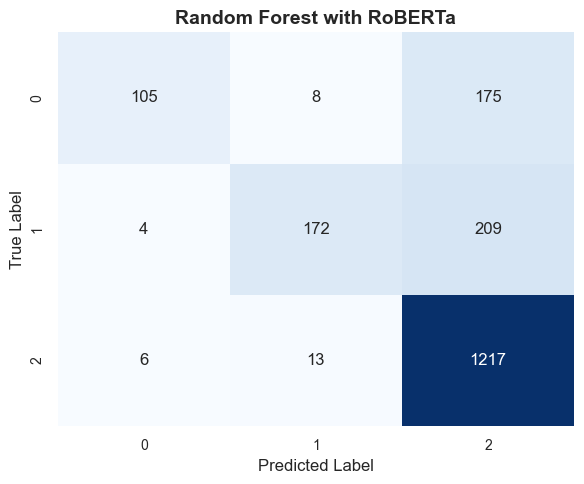

In [ ]:
# Plot confusion matrix
plot_confusion_matrix(val_labels, y_val_pred_roberta, title=title, labels=[0, 1, 2], cmap="Blues")

<div class="alert alert-block alert-success">

# **5.** **Logistic Regression**

<div>

## **5.1** Bag of Words

### **5.1.1** Unigrams

In [ ]:
model_lr = LogisticRegression(
    penalty=penalty, 
    solver=solver, 
    l1_ratio=l1_ratio, 
    C=C, 
    class_weight=class_weight, 
    max_iter=max_iter, 
    multi_class=multi_class
)

X_bow_unigrams, y_train_pred_bow_unigrams, y_val_pred_bow_unigrams, bow_unigrams = embedding_bow(x_train=x_train, y_train=y_train, x_val=x_val, model=model_lr)

In [ ]:
title = "LR BoW Unigrams"

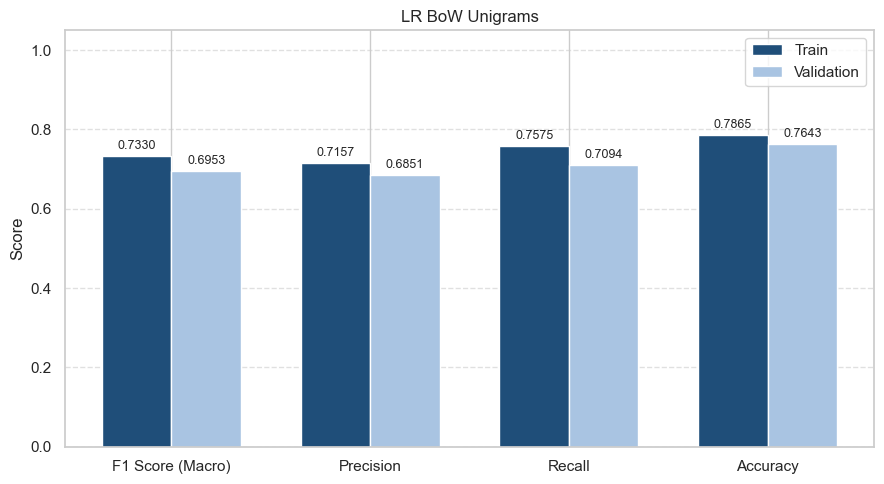

In [ ]:
metrics_df.append(get_metrics_df(title, y_train, y_train_pred_bow_unigrams, y_val, y_val_pred_bow_unigrams))

# Plot metrics
plot_metrics(y_train, y_train_pred_bow_unigrams, y_val, y_val_pred_bow_unigrams, title=title)

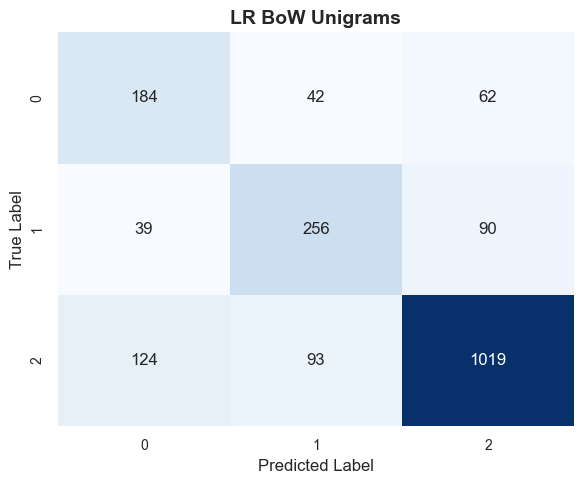

In [ ]:
plot_confusion_matrix(y_val, y_val_pred_bow_unigrams, title=title, labels=[0, 1, 2], cmap="Blues")

### **5.1.2** Unigrams + Bigrams

In [ ]:
model_lr = LogisticRegression(
    penalty=penalty, 
    solver=solver, 
    l1_ratio=l1_ratio, 
    C=C, 
    class_weight=class_weight, 
    max_iter=max_iter, 
    multi_class=multi_class
)

X_bow_bigrams, y_train_pred_bow_bigrams, y_val_pred_bow_bigrams, bow_bigrams = embedding_bow(x_train=x_train, y_train=y_train, x_val=x_val, model=model_lr, ngram_range=(1,2))

In [ ]:
title = "LR BoW Bigrams"

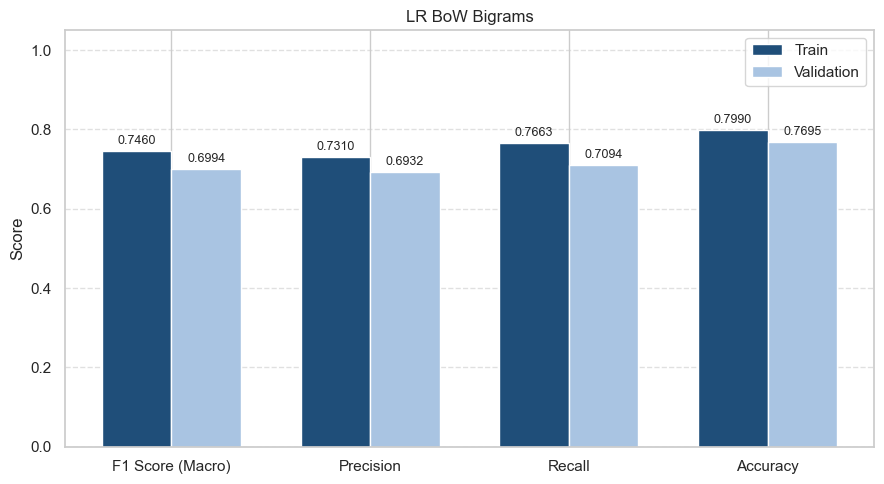

In [ ]:
metrics_df.append(get_metrics_df(title, y_train, y_train_pred_bow_bigrams, y_val, y_val_pred_bow_bigrams))

# Plot metrics
plot_metrics(y_train, y_train_pred_bow_bigrams, y_val, y_val_pred_bow_bigrams, title=title)

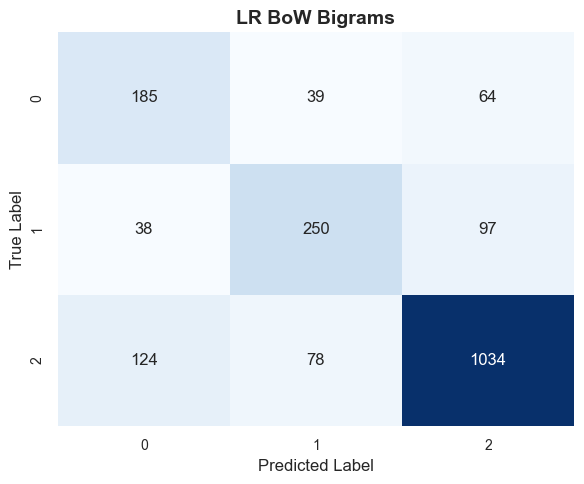

In [ ]:
plot_confusion_matrix(y_val, y_val_pred_bow_bigrams, title=title, labels=[0, 1, 2], cmap="Blues")

## **5.2** TF-IDF

### **5.2.1** Unigrams

In [ ]:
model_lr = LogisticRegression(
    penalty=penalty, 
    solver=solver, 
    l1_ratio=l1_ratio, 
    C=C, 
    class_weight=class_weight, 
    max_iter=max_iter, 
    multi_class=multi_class
)

X_tfidf_unigrams, y_train_pred_tfidf_unigrams, y_val_pred_tfidf_unigrams, tfidf_unigrams = embedding_tfidf(x_train=x_train, y_train=y_train, x_val=x_val, max_df=max_df, model=model_lr,oversampling_function=oversample)

In [ ]:
title = "LR TF-IDF Unigrams"

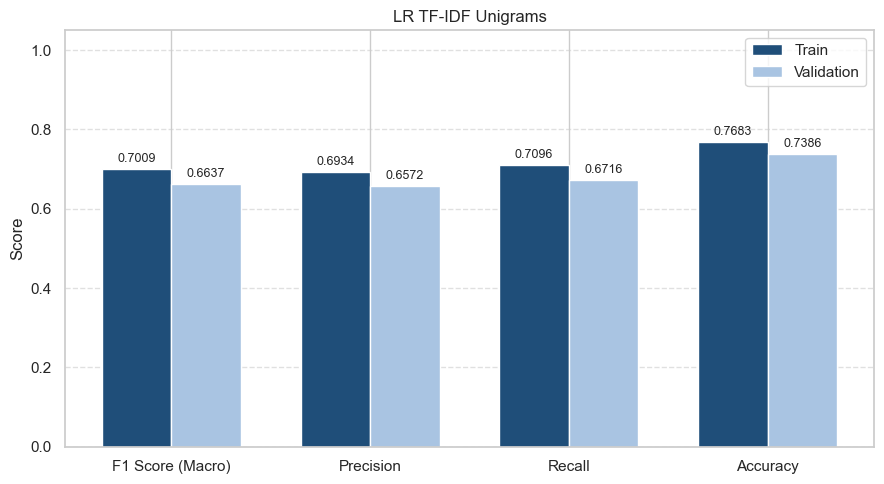

In [ ]:
metrics_df.append(get_metrics_df(title, y_train, y_train_pred_tfidf_unigrams, y_val, y_val_pred_tfidf_unigrams))

# Plot metrics
plot_metrics(y_train, y_train_pred_tfidf_unigrams, y_val, y_val_pred_tfidf_unigrams, title=title)

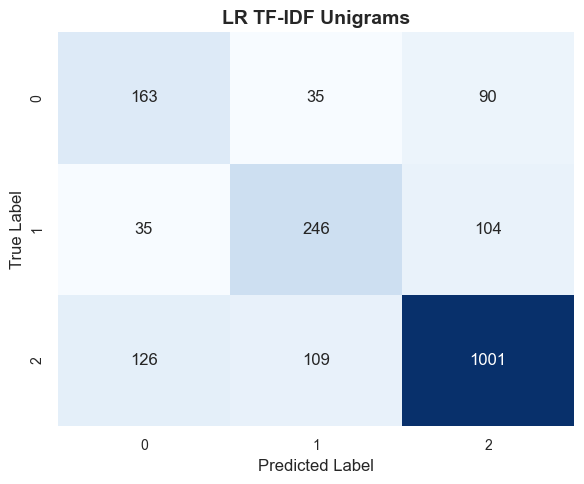

In [ ]:
plot_confusion_matrix(y_val, y_val_pred_tfidf_unigrams, title=title, labels=[0, 1, 2], cmap="Blues")

### **5.2.2** Bigrams

In [ ]:
model_lr = LogisticRegression(
    penalty=penalty, 
    solver=solver, 
    l1_ratio=l1_ratio, 
    C=C, 
    class_weight=class_weight, 
    max_iter=max_iter, 
    multi_class=multi_class
)

X_tfidf_bigrams, y_train_pred_tfidf_bigrams, y_val_pred_tfidf_bigrams, tfidf_bigrams = embedding_tfidf(x_train=x_train, y_train=y_train, x_val=x_val, max_df=max_df, model=model_lr, ngram_range=(1,2))

In [ ]:
title = "LR TF-IDF Bigrams"

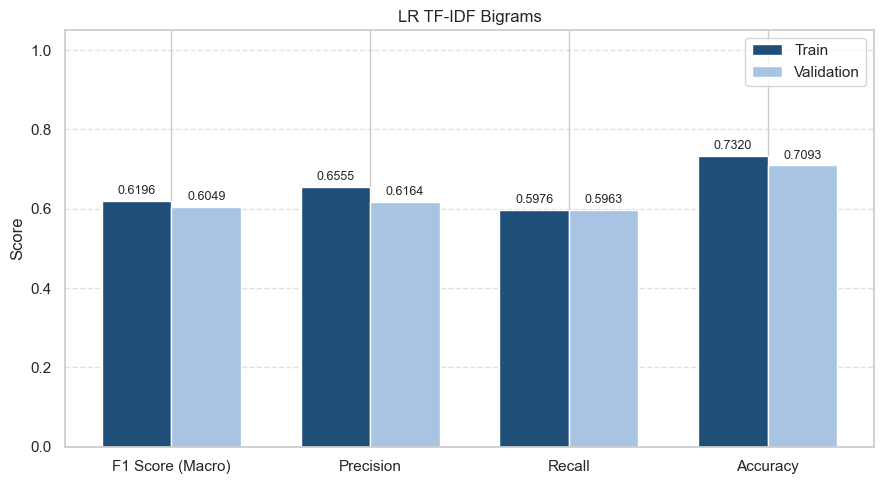

In [ ]:
metrics_df.append(get_metrics_df(title, y_train, y_train_pred_tfidf_bigrams, y_val, y_val_pred_tfidf_bigrams))

# Plot metrics
plot_metrics(y_train, y_train_pred_tfidf_bigrams, y_val, y_val_pred_tfidf_bigrams, title=title)

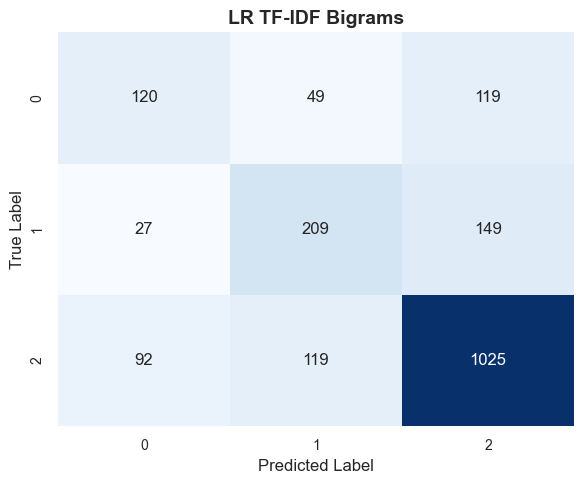

In [ ]:
plot_confusion_matrix(y_val, y_val_pred_tfidf_bigrams, title=title, labels=[0, 1, 2], cmap="Blues")

## **5.3** Word2Vec

### **5.3.1** Minimum count = 1

In [ ]:
model_lr = LogisticRegression(
    penalty=penalty, 
    solver=solver, 
    l1_ratio=l1_ratio, 
    C=C, 
    class_weight=class_weight, 
    max_iter=max_iter, 
    multi_class=multi_class
)

X_train_vec, y_train_pred_vec, y_val_pred_vec = embedding_word2vec(x_train=x_train, y_train=y_train, x_val=x_val, window=window, min_count=min_count, model=model_lr)

In [ ]:
title = "LR Word2Vec"

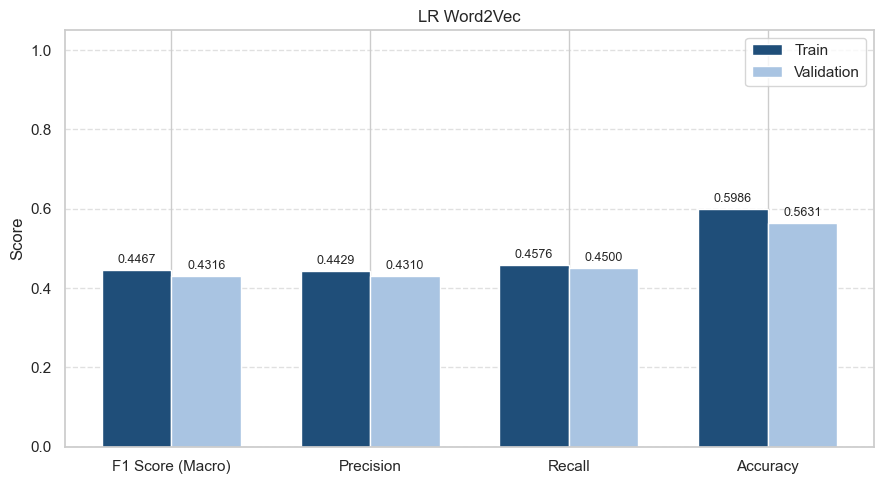

In [ ]:
metrics_df.append(get_metrics_df(title, y_train, y_train_pred_vec, y_val, y_val_pred_vec))

# Plot metrics
plot_metrics(y_train, y_train_pred_vec, y_val, y_val_pred_vec, title=title)

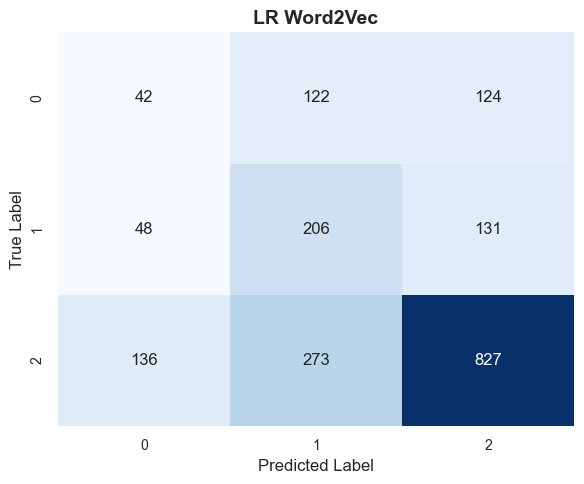

In [ ]:
plot_confusion_matrix(y_val, y_val_pred_vec, title=title, labels=[0, 1, 2], cmap="Blues")

### **5.3.2** Minimum count based on percentile

In [ ]:
X_train_vec, y_train_pred_vec, y_val_pred_vec = embedding_word2vec(x_train=x_train, y_train=y_train, x_val=x_val, window=window, min_count=percentile_75, model=model_lr)

In [ ]:
title = "LR Word2Vec - Min count = 75th percentile"

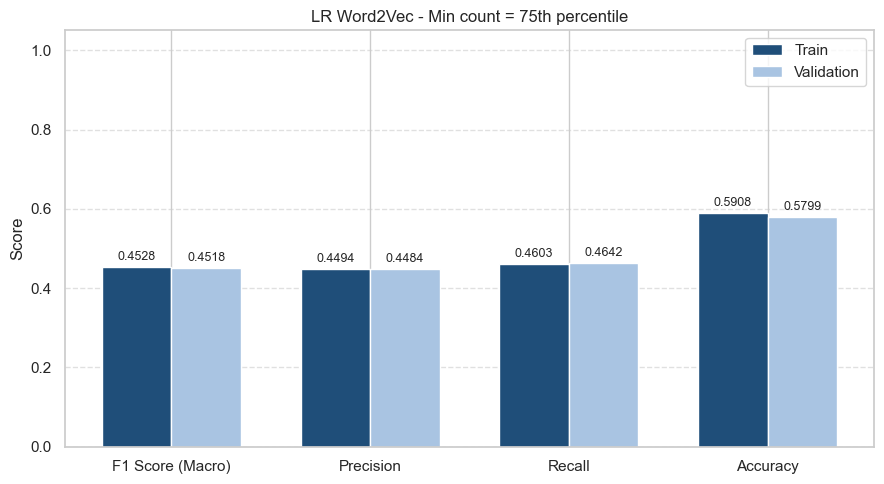

In [ ]:
metrics_df.append(get_metrics_df(title, y_train, y_train_pred_vec, y_val, y_val_pred_vec))

# Plot metrics
plot_metrics(y_train, y_train_pred_vec, y_val, y_val_pred_vec, title=title)

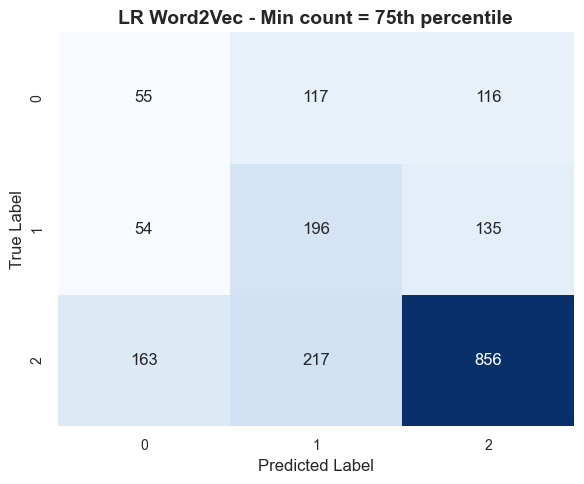

In [ ]:
plot_confusion_matrix(y_val, y_val_pred_vec, title=title, labels=[0, 1, 2], cmap="Blues")

## **5.4** Glove

In [ ]:
model_lr = LogisticRegression(
    penalty=penalty, 
    solver=solver, 
    l1_ratio=l1_ratio, 
    C=C, 
    class_weight=class_weight, 
    max_iter=max_iter, 
    multi_class=multi_class
)

X_train_glove_avg, y_train_pred_glove, y_val_pred_glove = embedding_glove(x_train=x_train, y_train=y_train, x_val=x_val, model_glove = glove_model, emb_size=emb_size, model=model_lr)

100%|██████████| 1909/1909 [00:00<00:00, 8469.87it/s]


In [ ]:
title = "LR Glove"

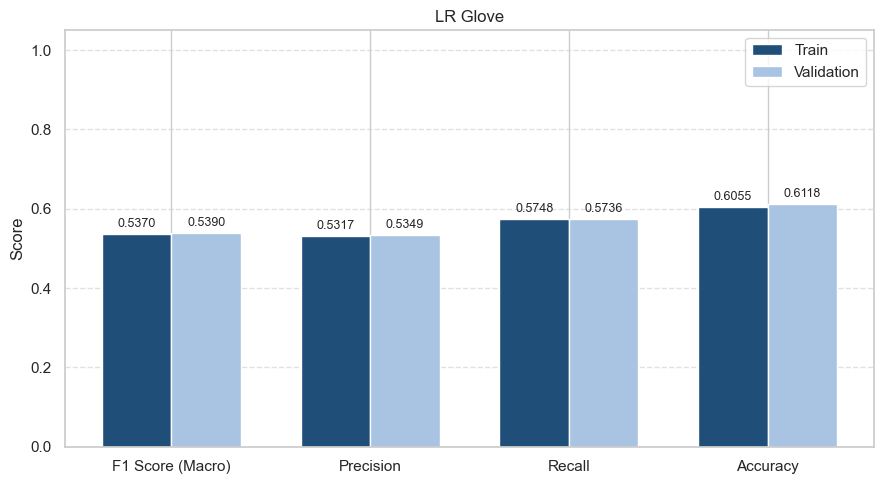

In [ ]:
metrics_df.append(get_metrics_df(title, y_train, y_train_pred_glove, y_val, y_val_pred_glove))

# Plot metrics
plot_metrics(y_train, y_train_pred_glove, y_val, y_val_pred_glove, title=title)

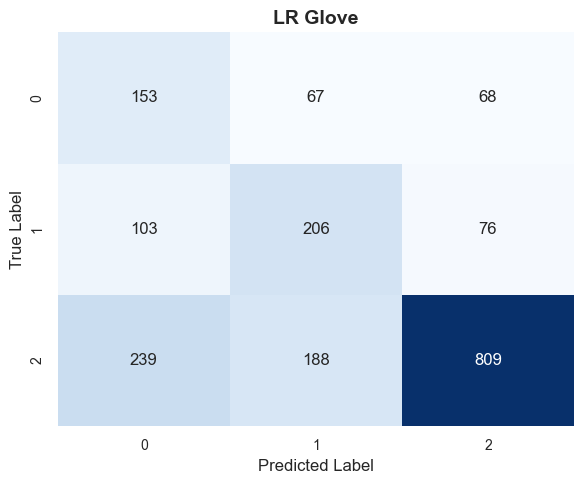

In [ ]:
plot_confusion_matrix(y_val, y_val_pred_glove, title=title, labels=[0, 1, 2], cmap="Blues")

## **5.5** Text Embedding 3 Small - EXTRA

In [ ]:
model_lr = LogisticRegression(
    penalty=penalty, 
    solver=solver, 
    l1_ratio=l1_ratio, 
    C=C, 
    class_weight=class_weight, 
    max_iter=max_iter, 
    multi_class=multi_class
)

X_train_te3s, y_train_pred_te3s,y_val_pred_te3s = embedding_te3s(train_texts=train_texts,
                                                                 train_labels=train_labels,
                                                                 val_texts = val_texts, 
                                                                 cache_file_train="X_train_te3s_embeddings.pkl", 
                                                                 cache_file_val="X_val_te3s_embeddings.pkl",
                                                                 client=client,
                                                                 model_te3s=model_te3s,
                                                                 batch_size=32,
                                                                 model=model_lr)

Loading embeddings from X_train_te3s_embeddings.pkl...
Loading embeddings from X_val_te3s_embeddings.pkl...


In [ ]:
# Define the title for the metrics and plots
title = "Logistic Regression with Text Embedding 3 Small"

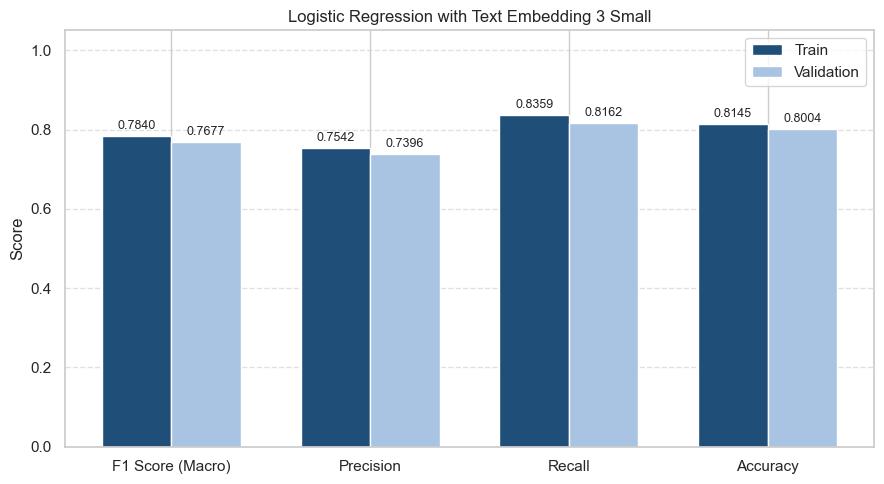

In [ ]:
# Get metrics DataFrame
metrics_df.append(get_metrics_df(title, train_labels, y_train_pred_te3s, val_labels, y_val_pred_te3s))
metrics_df

# Plot metrics
plot_metrics(train_labels, y_train_pred_te3s, val_labels, y_val_pred_te3s, title=title)

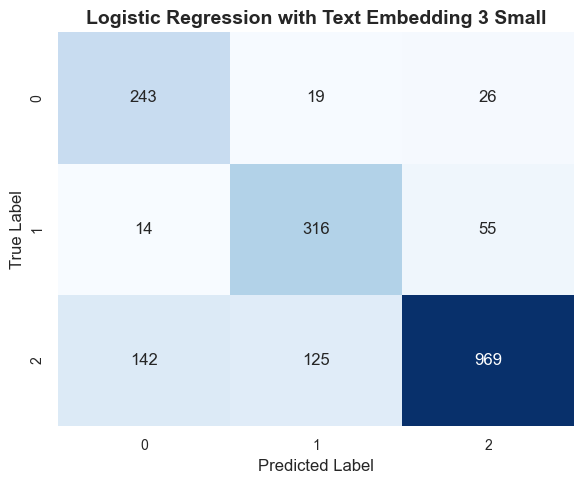

In [ ]:
# Plot confusion matrix
plot_confusion_matrix(val_labels, y_val_pred_te3s, title=title, labels=[0, 1, 2], cmap="Blues")

## **5.6** Twitter Roberta Base - EXTRA

In [ ]:
model_lr = LogisticRegression(
    penalty=penalty, 
    solver=solver, 
    l1_ratio=l1_ratio, 
    C=C, 
    class_weight=class_weight, 
    max_iter=max_iter, 
    multi_class=multi_class
)

X_train_roberta, y_train_pred_roberta,y_val_pred_roberta = embedding_roberta(train_texts=train_texts,
                                                                 train_labels=train_labels,
                                                                 val_texts = val_texts, 
                                                                 cache_file_train="X_train_te3s_embeddings.pkl", 
                                                                 cache_file_val="X_val_te3s_embeddings.pkl",
                                                                 tokenizer_roberta=tokenizer_roberta,
                                                                 model_roberta=model_roberta,
                                                                 batch_size=32,
                                                                 model=model_lr)

Loading RoBERTa embeddings from X_train_te3s_embeddings.pkl...
Loading RoBERTa embeddings from X_val_te3s_embeddings.pkl...


In [ ]:
# Define the title for the metrics and plots
title = "Logistic Regression with RoBERTa"

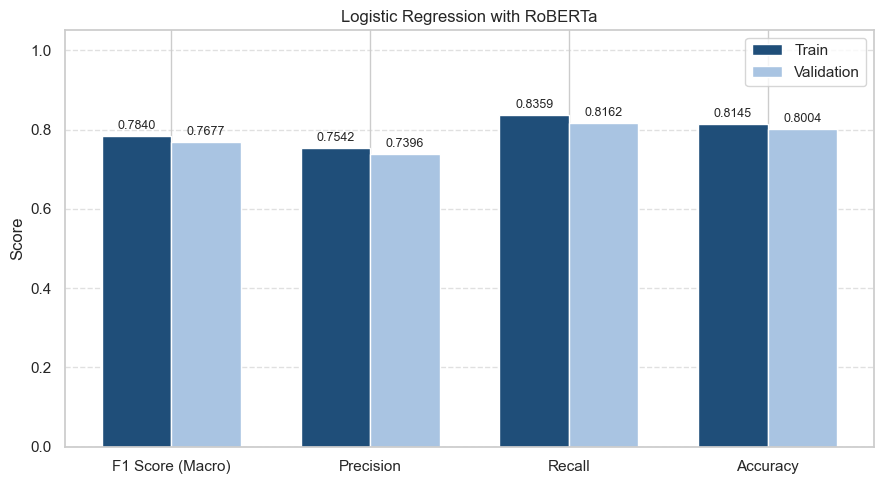

In [ ]:
# Get metrics DataFrame
metrics_df.append(get_metrics_df(title, train_labels, y_train_pred_roberta, val_labels, y_val_pred_roberta))
metrics_df

# Plot metrics
plot_metrics(train_labels, y_train_pred_roberta, val_labels, y_val_pred_roberta, title=title)

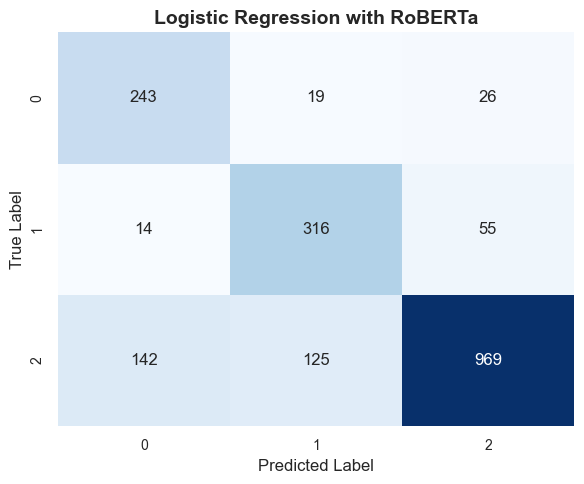

In [ ]:
# Plot confusion matrix
plot_confusion_matrix(val_labels, y_val_pred_roberta, title=title, labels=[0, 1, 2], cmap="Blues")

<div class="alert alert-block alert-success">

# **6.** **XGBoost**

<div>

## **6.1** Bag of Words

### **6.1.1** Unigrams

In [ ]:
model_xgb =  XGBClassifier(
    objective=objective, 
    num_class=num_class, 
    eval_metric=eval_metric, 
    learning_rate=0.8, 
    max_depth=max_depth_xgboost, 
    n_estimators=n_estimators, 
    subsample=subsample, 
    colsample_bytree=colsample_bytree,
    scale_pos_weight=scale_pos_weight
)

# each term is marked as present or not per document - good for short text
X_bow_unigrams, y_train_pred_bow_unigrams, y_val_pred_bow_unigrams, bow_unigrams = embedding_bow(x_train=x_train, y_train=y_train, x_val=x_val, model=model_xgb)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [01:32:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [ ]:
title = "XGB BoW Unigrams"

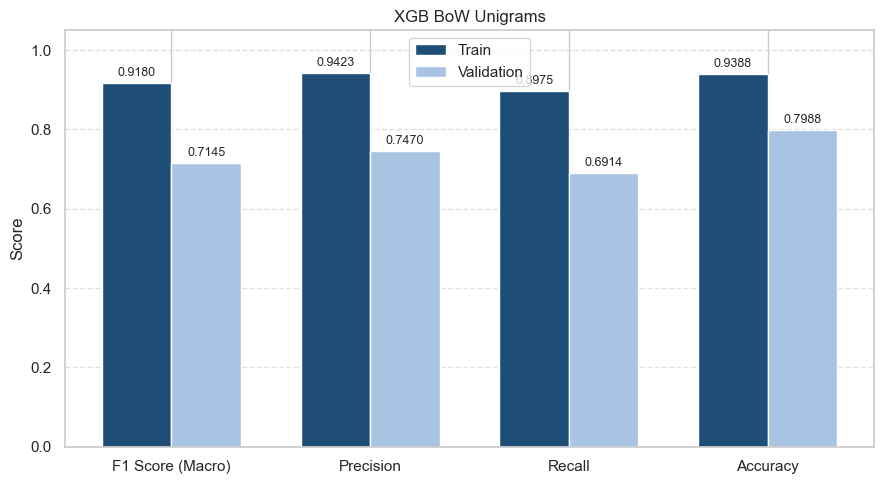

In [ ]:
metrics_df.append(get_metrics_df(title, y_train, y_train_pred_bow_unigrams, y_val, y_val_pred_bow_unigrams))

# Plot metrics
plot_metrics(y_train, y_train_pred_bow_unigrams, y_val, y_val_pred_bow_unigrams, title=title)

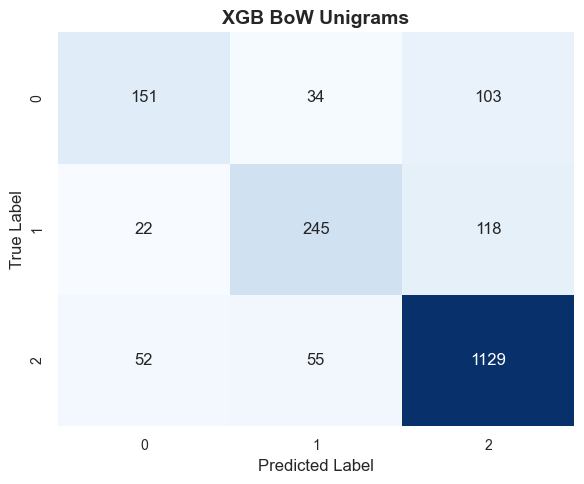

In [ ]:
plot_confusion_matrix(y_val, y_val_pred_bow_unigrams, title=title, labels=[0, 1, 2], cmap="Blues")

### **6.1.2** Unigrams + Bigrams

In [ ]:
model_xgb =  XGBClassifier(
    objective=objective, 
    num_class=num_class, 
    eval_metric=eval_metric, 
    use_label_encoder=use_label_encoder, 
    learning_rate=learning_rate, 
    max_depth=max_depth_xgboost, 
    n_estimators=n_estimators_xgboost, 
    subsample=subsample, 
    colsample_bytree=colsample_bytree
)

X_bow_bigrams, y_train_pred_bow_bigrams, y_val_pred_bow_bigrams, bow_bigrams = embedding_bow(x_train=x_train, y_train=y_train, x_val=x_val, model=model_xgb, ngram_range=(1,2))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [01:33:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [ ]:
title = "XGB BoW Bigrams"

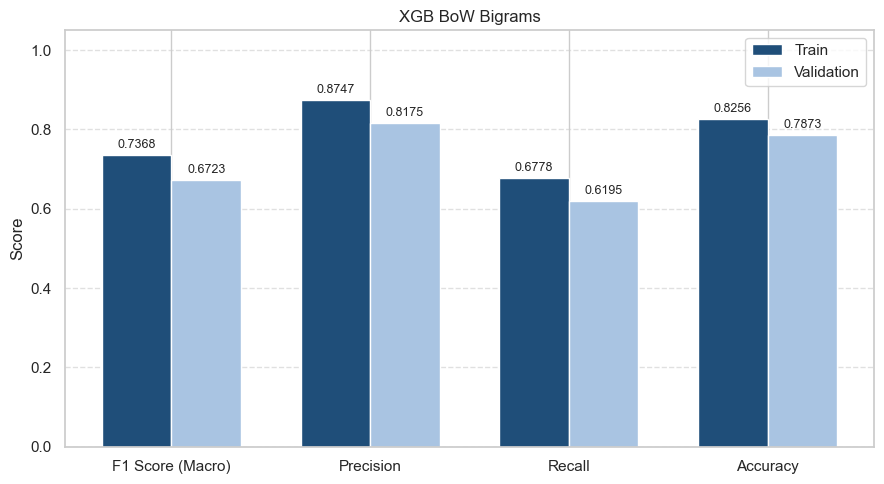

In [ ]:
metrics_df.append(get_metrics_df(title, y_train, y_train_pred_bow_bigrams, y_val, y_val_pred_bow_bigrams))

# Plot metrics
plot_metrics(y_train, y_train_pred_bow_bigrams, y_val, y_val_pred_bow_bigrams, title=title)

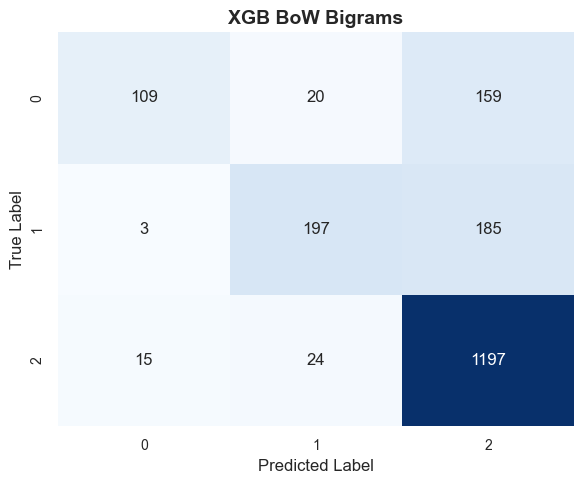

In [ ]:
plot_confusion_matrix(y_val, y_val_pred_bow_bigrams, title=title, labels=[0, 1, 2], cmap="Blues")

## **6.2** TF-IDF

### **6.2.1** Unigrams

In [ ]:
model_xgb =  XGBClassifier(
    objective=objective, 
    num_class=num_class, 
    eval_metric=eval_metric, 
    use_label_encoder=use_label_encoder, 
    learning_rate=learning_rate, 
    max_depth=max_depth_xgboost, 
    n_estimators=n_estimators_xgboost, 
    subsample=subsample, 
    colsample_bytree=colsample_bytree
)

X_tfidf_unigrams, y_train_pred_tfidf_unigrams, y_val_pred_tfidf_unigrams, tfidf_unigrams = embedding_tfidf(x_train=x_train, y_train=y_train, x_val=x_val, max_df=max_df, model=model_xgb,oversampling_function=oversample)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [01:35:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [ ]:
title = "XGB TF-IDF Unigrams"

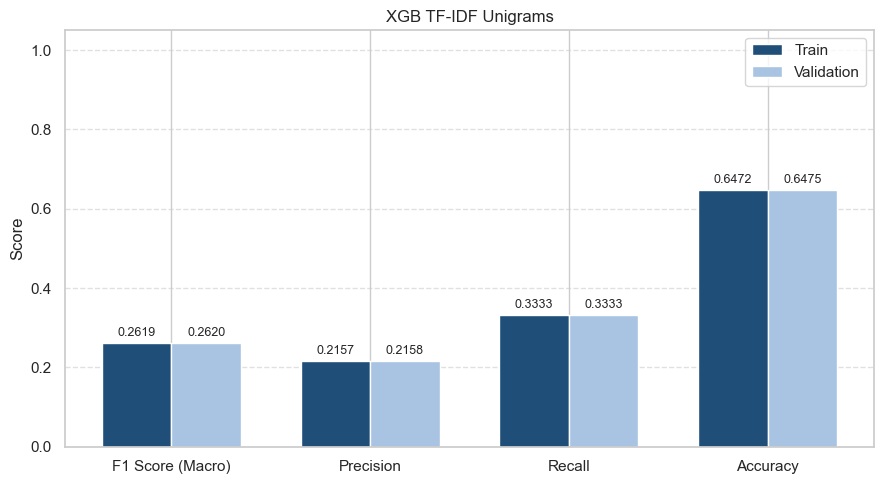

In [ ]:
metrics_df.append(get_metrics_df(title, y_train, y_train_pred_tfidf_unigrams, y_val, y_val_pred_tfidf_unigrams))

# Plot metrics
plot_metrics(y_train, y_train_pred_tfidf_unigrams, y_val, y_val_pred_tfidf_unigrams, title=title)

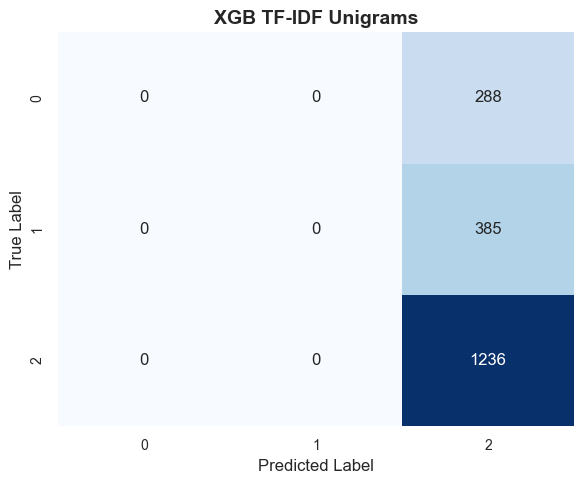

In [ ]:
plot_confusion_matrix(y_val, y_val_pred_tfidf_unigrams, title=title, labels=[0, 1, 2], cmap="Blues")

### **6.2.2** Bigrams

In [ ]:
model_xgb =  XGBClassifier(
    objective=objective, 
    num_class=num_class, 
    eval_metric=eval_metric, 
    use_label_encoder=use_label_encoder, 
    learning_rate=learning_rate, 
    max_depth=max_depth_xgboost, 
    n_estimators=n_estimators_xgboost, 
    subsample=subsample, 
    colsample_bytree=colsample_bytree
)

X_tfidf_bigrams, y_train_pred_tfidf_bigrams, y_val_pred_tfidf_bigrams, tfidf_bigrams = embedding_tfidf(x_train=x_train, y_train=y_train, x_val=x_val, max_df=max_df, model=model_xgb, ngram_range=(1,2))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [01:43:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [ ]:
title = "XGB TF-IDF Bigrams"

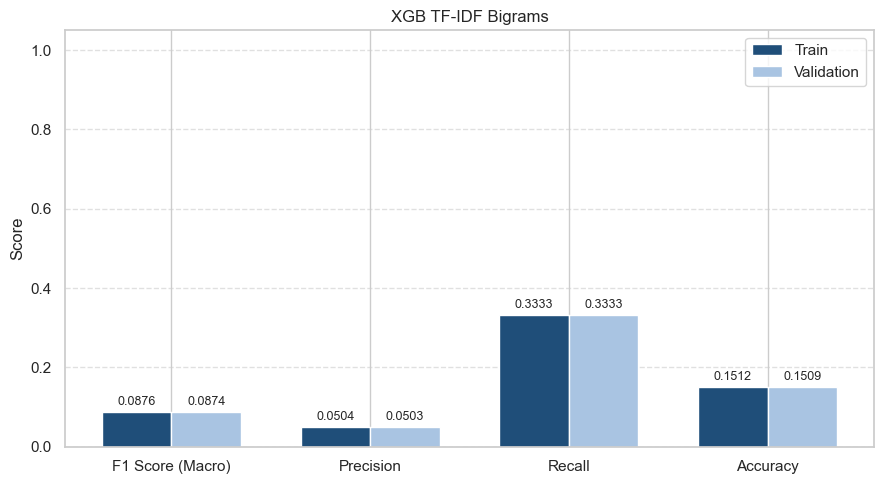

In [ ]:
metrics_df.append(get_metrics_df(title, y_train, y_train_pred_tfidf_bigrams, y_val, y_val_pred_tfidf_bigrams))

# Plot metrics
plot_metrics(y_train, y_train_pred_tfidf_bigrams, y_val, y_val_pred_tfidf_bigrams, title=title)

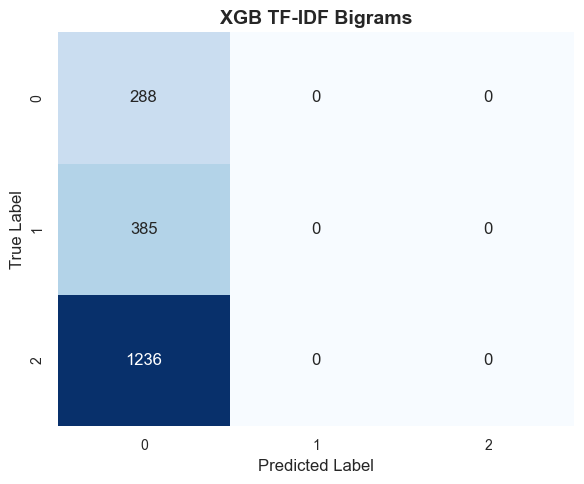

In [ ]:
plot_confusion_matrix(y_val, y_val_pred_tfidf_bigrams, title=title, labels=[0, 1, 2], cmap="Blues")

## **6.3** Word2Vec

### **6.3.1** Minimum count = 1


In [ ]:
model_xgb =  XGBClassifier(
    objective=objective, 
    num_class=num_class, 
    eval_metric=eval_metric, 
    use_label_encoder=use_label_encoder, 
    learning_rate=learning_rate, 
    max_depth=max_depth_xgboost, 
    n_estimators=n_estimators_xgboost, 
    subsample=subsample, 
    colsample_bytree=colsample_bytree
)

X_train_vec, y_train_pred_vec, y_val_pred_vec = embedding_word2vec(x_train=x_train, y_train=y_train, x_val=x_val, window=window, min_count=min_count, model=model_xgb)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [02:05:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [ ]:
title = "XGB Word2Vec"

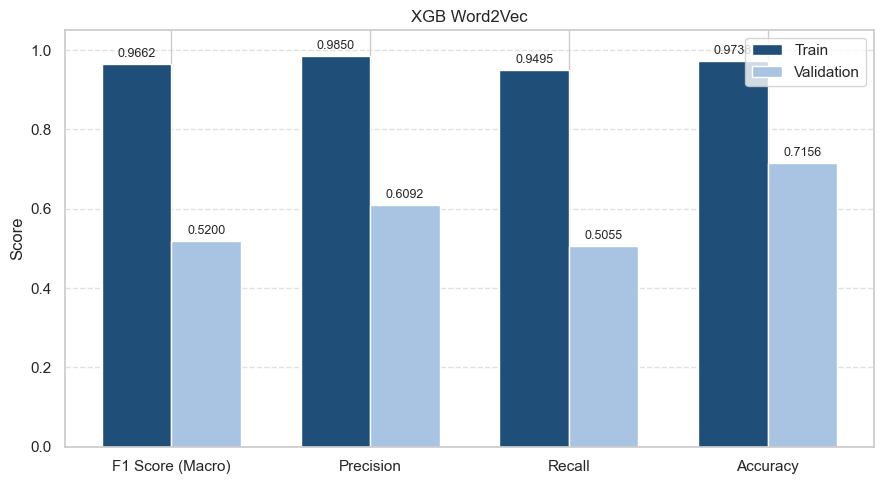

In [ ]:
metrics_df.append(get_metrics_df(title, y_train, y_train_pred_vec, y_val, y_val_pred_vec))

# Plot metrics
plot_metrics(y_train, y_train_pred_vec, y_val, y_val_pred_vec, title=title)

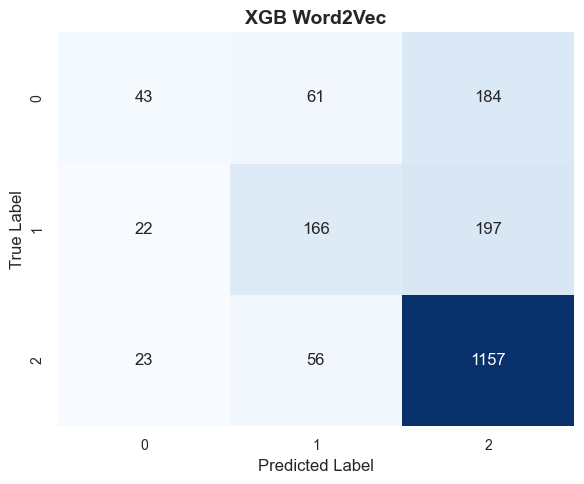

In [ ]:
plot_confusion_matrix(y_val, y_val_pred_vec, title=title, labels=[0, 1, 2], cmap="Blues")

### **6.3.2** Minimum count based on percentile

In [ ]:
model_xgb =  XGBClassifier(
    objective=objective, 
    num_class=num_class, 
    eval_metric=eval_metric, 
    use_label_encoder=use_label_encoder, 
    learning_rate=learning_rate, 
    max_depth=max_depth_xgboost, 
    n_estimators=n_estimators_xgboost, 
    subsample=subsample, 
    colsample_bytree=colsample_bytree
)

X_train_vec, y_train_pred_vec, y_val_pred_vec = embedding_word2vec(x_train=x_train, y_train=y_train, x_val=x_val, window=window, min_count=percentile_75, model=model_xgb)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [02:06:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [ ]:
title = "XGB Word2Vec - Min count = 75th percentile"

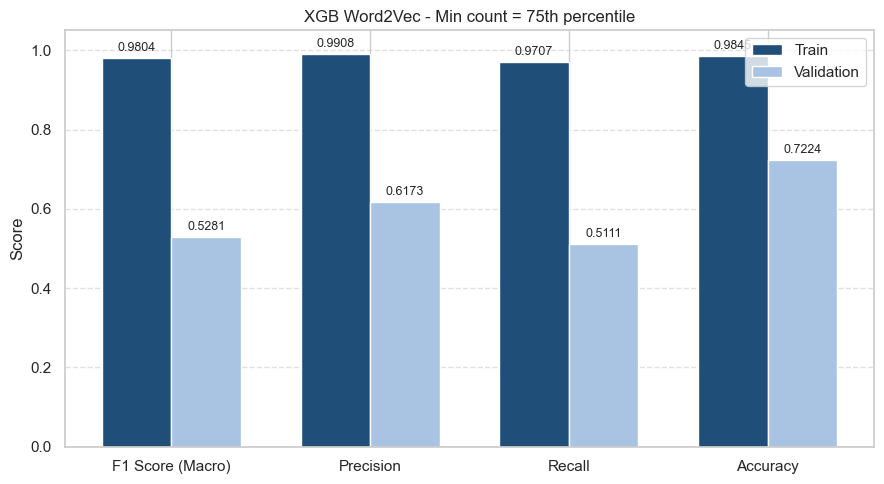

In [ ]:
metrics_df.append(get_metrics_df(title, y_train, y_train_pred_vec, y_val, y_val_pred_vec))

# Plot metrics
plot_metrics(y_train, y_train_pred_vec, y_val, y_val_pred_vec, title=title)

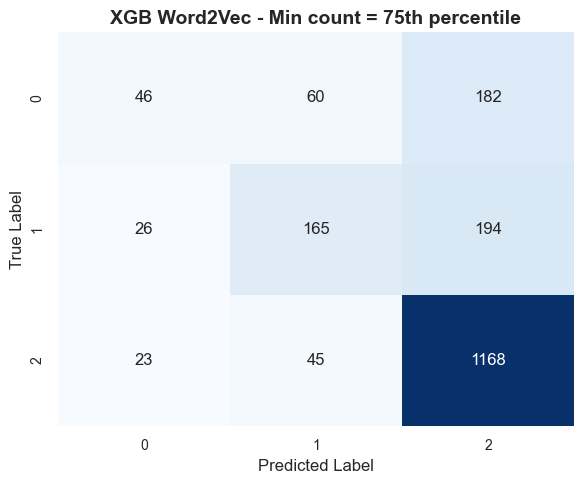

In [ ]:
plot_confusion_matrix(y_val, y_val_pred_vec, title=title, labels=[0, 1, 2], cmap="Blues")

## **6.4** Glove

In [ ]:
model_xgb =  XGBClassifier(
    objective=objective, 
    num_class=num_class, 
    eval_metric=eval_metric, 
    use_label_encoder=use_label_encoder, 
    learning_rate=learning_rate, 
    max_depth=max_depth_xgboost, 
    n_estimators=n_estimators_xgboost, 
    subsample=subsample, 
    colsample_bytree=colsample_bytree
)

X_train_glove_avg, y_train_pred_glove, y_val_pred_glove = embedding_glove(x_train=x_train, y_train=y_train, x_val=x_val, model_glove = glove_model, emb_size=emb_size, model=model_xgb)

100%|██████████| 1909/1909 [00:01<00:00, 1396.05it/s]
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [02:08:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [ ]:
title = "XGB Glove"

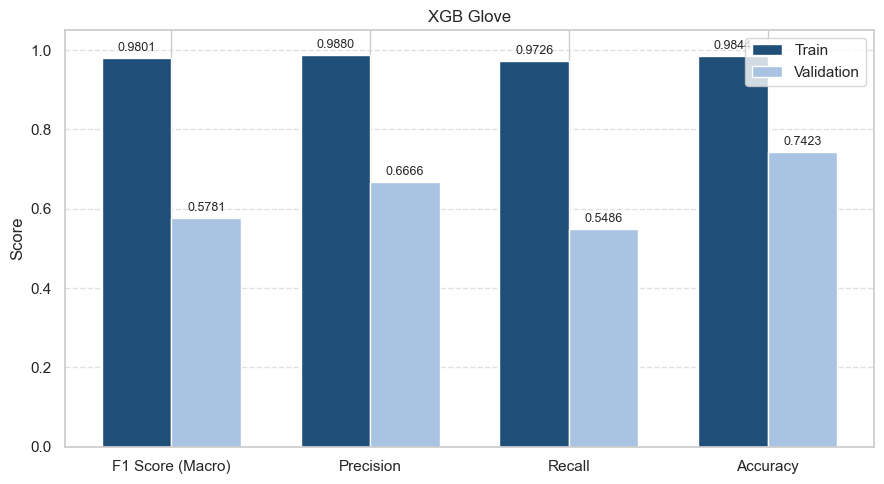

In [ ]:
metrics_df.append(get_metrics_df(title, y_train, y_train_pred_glove, y_val, y_val_pred_glove))

# Plot metrics
plot_metrics(y_train, y_train_pred_glove, y_val, y_val_pred_glove, title=title)

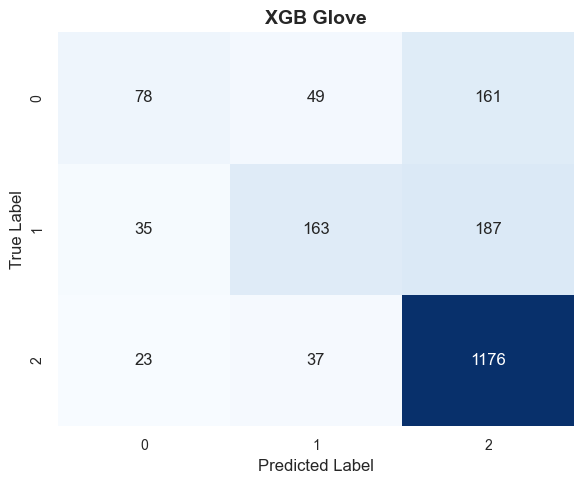

In [ ]:
plot_confusion_matrix(y_val, y_val_pred_glove, title=title, labels=[0, 1, 2], cmap="Blues")

## **6.5** Text Embedding 3 Small - EXTRA

In [ ]:
model_xgb =  XGBClassifier(
    objective=objective, 
    num_class=num_class, 
    eval_metric=eval_metric, 
    use_label_encoder=use_label_encoder, 
    learning_rate=learning_rate, 
    max_depth=max_depth_xgboost, 
    n_estimators=n_estimators_xgboost, 
    subsample=subsample, 
    colsample_bytree=colsample_bytree
)

X_train_te3s, y_train_pred_te3s,y_val_pred_te3s = embedding_te3s(train_texts=train_texts,
                                                                 train_labels=train_labels,
                                                                 val_texts = val_texts, 
                                                                 cache_file_train="X_train_te3s_embeddings.pkl", 
                                                                 cache_file_val="X_val_te3s_embeddings.pkl",
                                                                 client=client,
                                                                 model_te3s=model_te3s,
                                                                 batch_size=32,
                                                                 model=model_xgb)

Loading embeddings from X_train_te3s_embeddings.pkl...
Loading embeddings from X_val_te3s_embeddings.pkl...


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [02:09:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [ ]:
# Define the title for the metrics and plots
title = "XGB with Text Embedding 3 Small"

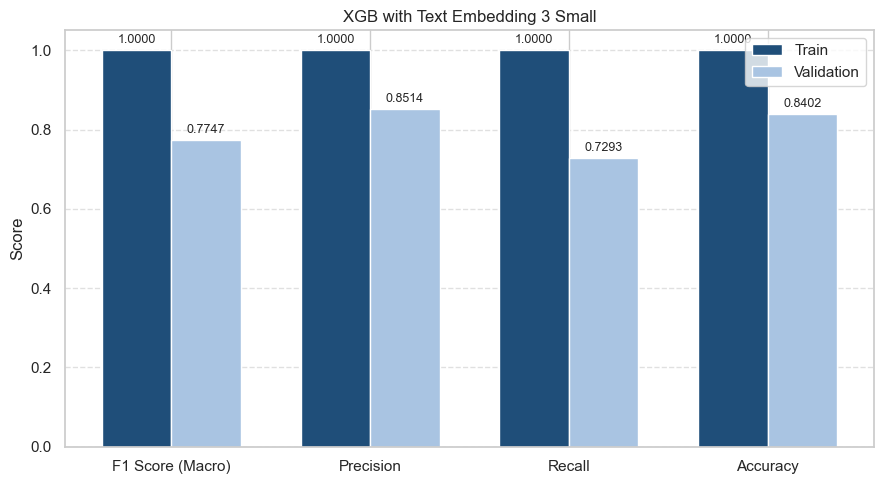

In [ ]:
# Get metrics DataFrame
metrics_df.append(get_metrics_df(title, train_labels, y_train_pred_te3s, val_labels, y_val_pred_te3s))
metrics_df

# Plot metrics
plot_metrics(train_labels, y_train_pred_te3s, val_labels, y_val_pred_te3s, title=title)

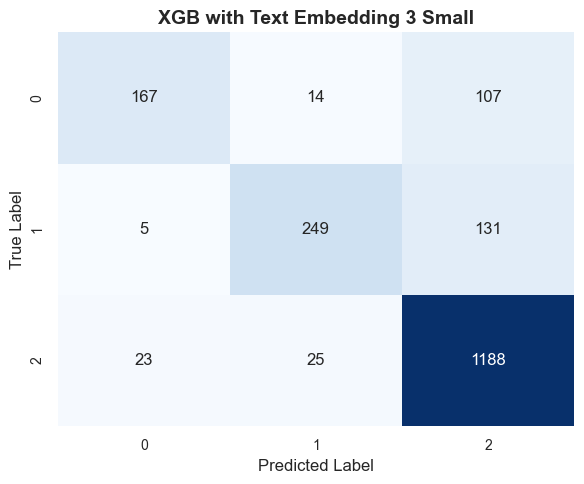

In [ ]:
# Plot confusion matrix
plot_confusion_matrix(val_labels, y_val_pred_te3s, title=title, labels=[0, 1, 2], cmap="Blues")

## **6.6** Twitter Roberta Base - EXTRA

In [ ]:
model_xgb =  XGBClassifier(
    objective=objective, 
    num_class=num_class, 
    eval_metric=eval_metric, 
    use_label_encoder=use_label_encoder, 
    learning_rate=learning_rate, 
    max_depth=max_depth_xgboost, 
    n_estimators=n_estimators_xgboost, 
    subsample=subsample, 
    colsample_bytree=colsample_bytree
)

X_train_roberta, y_train_pred_roberta,y_val_pred_roberta = embedding_roberta(train_texts=train_texts,
                                                                 train_labels=train_labels,
                                                                 val_texts = val_texts, 
                                                                 cache_file_train="X_train_te3s_embeddings.pkl", 
                                                                 cache_file_val="X_val_te3s_embeddings.pkl",
                                                                 tokenizer_roberta=tokenizer_roberta,
                                                                 model_roberta=model_roberta,
                                                                 batch_size=32,
                                                                 model=modelknn)

Loading RoBERTa embeddings from X_train_te3s_embeddings.pkl...
Loading RoBERTa embeddings from X_val_te3s_embeddings.pkl...


In [ ]:
# Define the title for the metrics and plots
title = "XGB with RoBERTa"

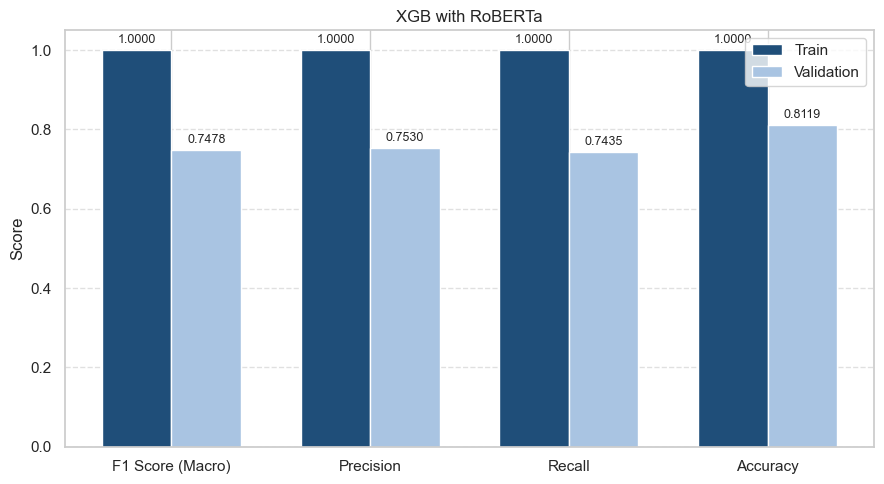

In [ ]:
# Get metrics DataFrame
metrics_df.append(get_metrics_df(title, train_labels, y_train_pred_roberta, val_labels, y_val_pred_roberta))
metrics_df

# Plot metrics
plot_metrics(train_labels, y_train_pred_roberta, val_labels, y_val_pred_roberta, title=title)

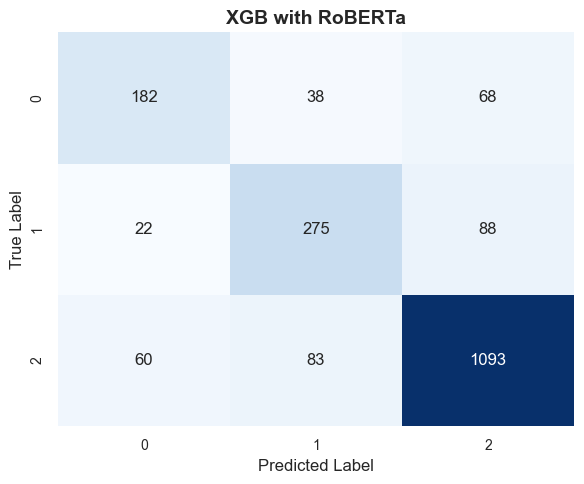

In [ ]:
# Plot confusion matrix
plot_confusion_matrix(val_labels, y_val_pred_roberta, title=title, labels=[0, 1, 2], cmap="Blues")

<div class="alert alert-block alert-success">

# **7.** **LSTM**

<div>

BoW and TF-IDF are not suitable for LSTM due to lack of sequential structure

## **7.1** Word2Vec

In [ ]:
model_lstm = Model(inputs=input_, outputs=output)
model_lstm.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics)

X_train_vec, y_train_pred_vec, y_val_pred_vec = embedding_word2vec_lstm(x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val, window=window, n_classes=num_class, batch_size=batch_size, epochs=epochs, model_lstm=model_lstm, min_count=min_count)

Epoch 1/10
477/477 ━━━━━━━━━━━━━━━━━━━━ 113s 182ms/step - auc: 0.5795 - categorical_accuracy: 0.6533 - loss: 0.8853 - precision: 0.6704 - recall: 0.5347 - val_auc: 0.6826 - val_categorical_accuracy: 0.6936 - val_loss: 0.8089 - val_precision: 0.7243 - val_recall: 0.6344
Epoch 2/10
477/477 ━━━━━━━━━━━━━━━━━━━━ 122s 256ms/step - auc: 0.7046 - categorical_accuracy: 0.6880 - loss: 0.7916 - precision: 0.7260 - recall: 0.6167 - val_auc: 0.6954 - val_categorical_accuracy: 0.7025 - val_loss: 0.7960 - val_precision: 0.7305 - val_recall: 0.6391
Epoch 3/10
477/477 ━━━━━━━━━━━━━━━━━━━━ 103s 216ms/step - auc: 0.7162 - categorical_accuracy: 0.6892 - loss: 0.7811 - precision: 0.7330 - recall: 0.6189 - val_auc: 0.7054 - val_categorical_accuracy: 0.7077 - val_loss: 0.7928 - val_precision: 0.7376 - val_recall: 0.6171
Epoch 4/10
477/477 ━━━━━━━━━━━━━━━━━━━━ 99s 208ms/step - auc: 0.7304 - categorical_accuracy: 0.6918 - loss: 0.7676 - precision: 0.7387 - recall: 0.6189 - val_auc: 0.7117 - val_categorical_ac

In [ ]:
title = "LSTM Word2Vec"

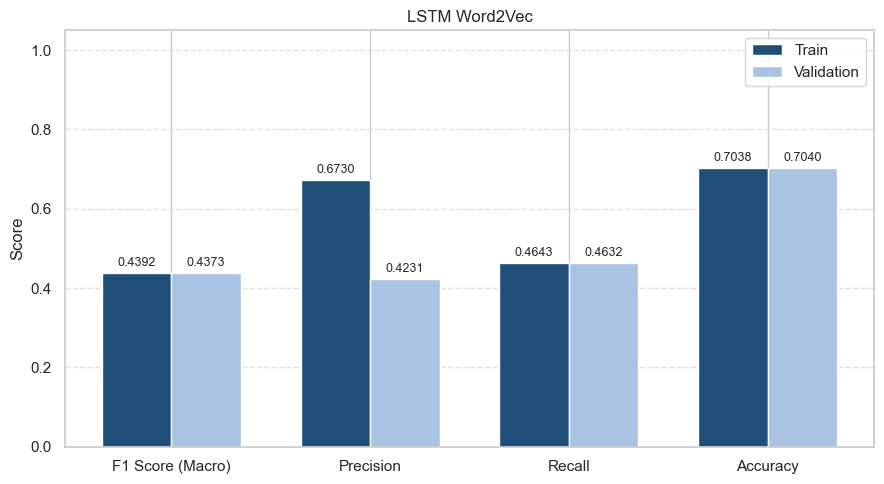

In [ ]:
metrics_df.append(get_metrics_df(title, y_train, y_train_pred_vec, y_val, y_val_pred_vec))

# Plot metrics
plot_metrics(y_train, y_train_pred_vec, y_val, y_val_pred_vec, title=title)

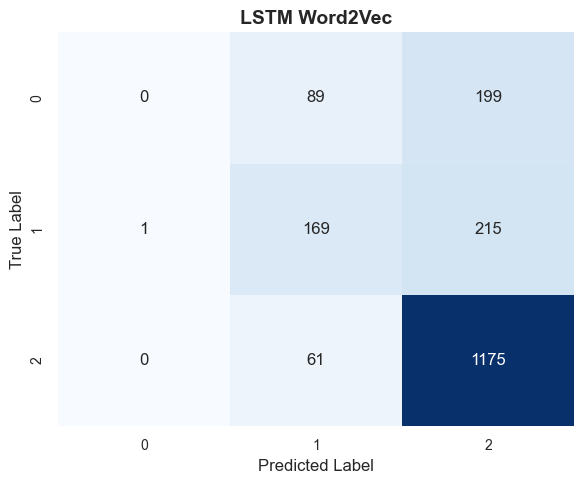

In [ ]:
plot_confusion_matrix(y_val, y_val_pred_vec, title=title, labels=[0, 1, 2], cmap="Blues")

## **7.2** Glove

In [ ]:
input_ = Input(shape=(26, 50))
x = Masking(mask_value=0.0)(input_)
x = Bidirectional(LSTM(units=units, return_sequences=False, dropout=dropout, recurrent_dropout=dropout))(x)
x = Dropout(dropout)(x)
output = Dense(num_class, activation='softmax')(x)

In [ ]:

def embedding_glove_lstm(x_train, y_train, x_val, y_val, model_glove, emb_size, model_lstm, n_classes=3, batch_size=16, epochs=10, oversampling_function=None, max_seq_len=None):
    X_train_vec = corpus2vec(x_train['text'], model_glove)
    X_val_vec = corpus2vec(x_val['text'], model_glove)

    if max_seq_len is None:
        max_seq_len = max(len(seq) for seq in X_train_vec)

    if emb_size is None:
        corpus = x_train['text']

        #get list with lenghts of sentences
        train_len = []
        for i in corpus:
            train_len.append(len(i))
        
        emb_size = max(train_len)
    
    # pad sequences (shape: n_samples x max_seq_len x emb_size)
    X_train_pad = pad_sequences(X_train_vec, maxlen=max_seq_len, dtype='float32', padding='post')
    X_val_pad   = pad_sequences(X_val_vec, maxlen=max_seq_len, dtype='float32', padding='post')

    if oversampling_function:
        X_train_pad, y_train = oversampling_function(X_train_pad, y_train)

    # one-hot encode targets 
    y_train_encoded = tf.one_hot(y_train, depth=n_classes)
    y_val_encoded = tf.one_hot(y_val, depth=n_classes)

    model_lstm.fit(X_train_pad, y_train_encoded, batch_size=batch_size, epochs=epochs, validation_data=(X_val_pad, y_val_encoded))

    y_train_pred = np.argmax(model_lstm.predict(X_train_pad), axis=1)
    y_val_pred = np.argmax(model_lstm.predict(X_val_pad), axis=1)

    return X_train_pad, y_train_pred, y_val_pred



In [ ]:
model_lstm = Model(inputs=input_, outputs=output)
model_lstm.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics)

X_train_glove, y_train_pred_glove, y_val_pred_glove = embedding_glove_lstm(x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val, model_glove = glove_model, n_classes=num_class, batch_size=batch_size, epochs=epochs, emb_size=emb_size, model_lstm=model_lstm)

100%|██████████| 1909/1909 [00:00<00:00, 4284.67it/s]


Epoch 1/10
477/477 ━━━━━━━━━━━━━━━━━━━━ 57s 99ms/step - auc: 0.6519 - categorical_accuracy: 0.6259 - loss: 0.8623 - precision: 0.6875 - recall: 0.5230 - val_auc: 0.7929 - val_categorical_accuracy: 0.7108 - val_loss: 0.7230 - val_precision: 0.7646 - val_recall: 0.6260
Epoch 2/10
477/477 ━━━━━━━━━━━━━━━━━━━━ 55s 114ms/step - auc: 0.7652 - categorical_accuracy: 0.6908 - loss: 0.7455 - precision: 0.7574 - recall: 0.6012 - val_auc: 0.8114 - val_categorical_accuracy: 0.7224 - val_loss: 0.6904 - val_precision: 0.7856 - val_recall: 0.6296
Epoch 3/10
477/477 ━━━━━━━━━━━━━━━━━━━━ 44s 92ms/step - auc: 0.7849 - categorical_accuracy: 0.6982 - loss: 0.7180 - precision: 0.7579 - recall: 0.6206 - val_auc: 0.8207 - val_categorical_accuracy: 0.7307 - val_loss: 0.6729 - val_precision: 0.7870 - val_recall: 0.6485
Epoch 4/10
477/477 ━━━━━━━━━━━━━━━━━━━━ 46s 96ms/step - auc: 0.8026 - categorical_accuracy: 0.7135 - loss: 0.6925 - precision: 0.7703 - recall: 0.6297 - val_auc: 0.8327 - val_categorical_accuracy

In [ ]:
title = "LSTM Glove"

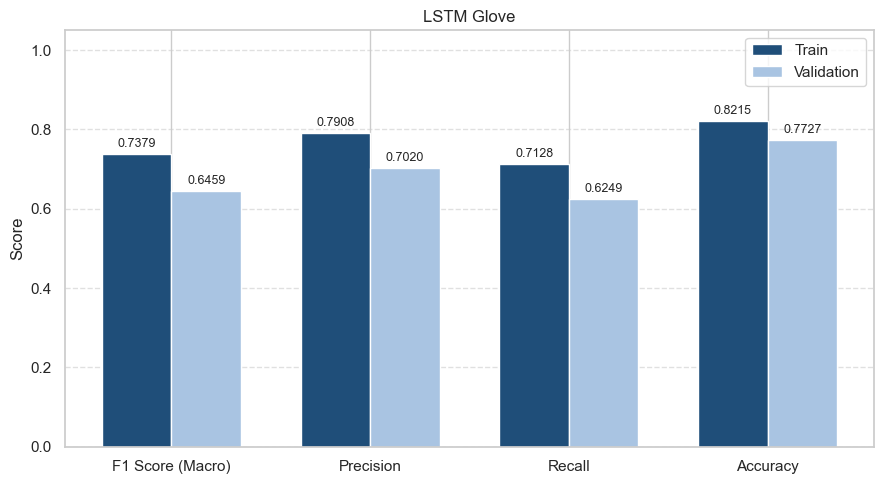

In [ ]:
metrics_df.append(get_metrics_df(title, y_train, y_train_pred_glove, y_val, y_val_pred_glove))

# Plot metrics
plot_metrics(y_train, y_train_pred_glove, y_val, y_val_pred_glove, title=title)

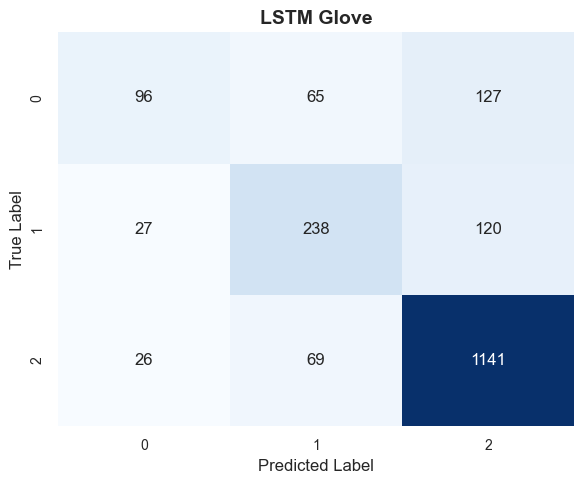

In [ ]:
plot_confusion_matrix(y_val, y_val_pred_glove, title=title, labels=[0, 1, 2], cmap="Blues")